In [116]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import os
import dhs_f
import fnmatch
import pyreadstat
import copy
#for meaningfull error massages turn of parallel_apply/ replace with apply
from pandarallel import pandarallel
import time
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import sys
# Initialization
pandarallel.initialize()
# Get the absolute path of the parent directory of the directory of the script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..")) + '/water/'
# Append the parent directory to sys.path
print(parent_dir)
sys.path.append(parent_dir)
import helper_utils as hu

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
/home/sven/pycharm/water/


In [117]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [118]:
###Options
#since_year = 2012
#drop south africa, egypt, tunesia, morocco
#drop_survey = ['MDGE6AFL', EGGE61FL,GHGE7IFL,NMGE61FL,ZAGE71FL,maybe:KMGE61FL]
drop_survey = ['EGGE61FL', 'ZAGE71FL']
#drop_countries = ['ZA', 'EG', 'TN', 'MA']
###DHS Version 6: 2008-2013
min_dhs_version = 6
#only extracts locations where these survey records are available #'HR' = household recode
additional_files = ['HH', 'HR']
###Paths
dhs_path = r"/mnt/datadisk/data/surveys/DHS_raw_data/"
dhs_extras_p = r"/mnt/datadisk/data/surveys/DHS_info/"
img_path = '/mnt/datadisk2/preprocessed/all/996x996_c432_fillmean_m2.5_rlocal channel mean_clipvoutlier_normZ_f31213/'
#weighting of simplified water sources for PCA
drinking_water_source_weighting = 'drinking_water_source_weighting.csv'
projects_p = r"/mnt/datadisk/data/Projects/water/"
pickle_f = projects_p + '/inputs/pickle_tmp'
locations_f = projects_p + '/inputs/' + 'all_locations_final.csv'
#walk folder for finding .tifs
walk_f = r"/mnt/datadisk/"
#Saves loaded Questions/dfs into pickle and reloads because of runtime
load_from_pickle = True
#might be split into urban/rural as well cf. below
out_f = projects_p + 'inputs/water_labels_strat_split.csv'
#export on HH level for further analysis (Imputation project Mrs. Pranti)
out_f_hh = projects_p + 'inputs/water_hh_all_strat_split.csv'

#Select based on keywords (sometimes the column names and column codes vary slightly)
#need 2 values for iterating correctly
###Note:
#these are not known beforehand but retrieved and filtered in [4] by meta.column_names_to_labels.items()
#this is kinda cumbersome and results in lots of writing differences, not exact the same wording etc.
#The problem with using one meta for all Questionnaires is that they usually do not have all answer possibilities 
#for all questionnaires and these might differ from Questionnaire to Questionnaire as well (Maybe only version
#specific - I think the answer possibilities are phrased differently for some countries though)
columns_to_keep_n_rename = {
                            ('month', 'interview'): 'month of interview', 
                            ('year', 'interview'): 'year of interview', 
                            ('total members in household', False): 'number of household members',
                            ('time', 'to', 'water source'): 'time to get to water source (minutes)',
                            ('location', 'source for water'): 'location of source for water', 
                            ('water', 'shortage'): 'water shortages',
                            ('water', 'not available'): 'water shortages'
                           }
#Select based on exact match
exact_match = {'case identification', 'country code and phase', 'cluster number', 'region', 'district', 
               'anything done to water to make safe to drink',
               'household number', 'number of household members', 'source of drinking water', 
               'source of non-drinking water'}
#actually keep these columns (after renaming and looking at completness of data)
#dropped everything with scarce data
named_columns_to_keep = ["case identification", "country code and phase", "cluster number", "household number",
                         "month of interview", "year of interview", "number of household members", "region", 
                         "source of drinking water", "GEID", "water shortages", 
                         "time to get to water source (minutes)", "location of source for water", 
                         "anything done to water to make safe to drink", "month of interview", 
                         "district", 'water shortages']
#calculate separately for urban/rural
split_urban_rural = False
#limit by year NOT IMPLEMENTED
#min_year = False
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

In [119]:
###load data, preselect water columns and save into pickle for faster reloading
#Note: Important to use meta files since column names and especially value labels are unambiguous
#unify column names and replace values
column_names_d = {}
bottled_d = {}
counter = 0
counter2 = {}
if not os.path.isfile(pickle_f) or not load_from_pickle:
    dhs_d_all, country_d, data_file_types_d, typ_l, dhs_dirs_d = \
        dhs_f.load_dhs_data(dhs_path, dhs_extras_p)
    pathes = {}
    
    #catch all files
    for i, types in dhs_d_all.items():
        #only extract files where Household Recode data is available
        for additional_file in additional_files:
            if 'GE' in types and additional_file in types:
                #only use HH if HR not available
                if additional_file == 'HR' or 'HR' not in types:
                    if int(i[2]) >= min_dhs_version:
                        for (dirrpath, dirrnames, filenames) in os.walk(dhs_dirs_d[i][types.index(additional_file)]):
                            for file in filenames:
                                if fnmatch.fnmatch(file, '*.sav') or fnmatch.fnmatch(file, '*.SAV'):
                                    #also get GE folder for matching
                                    splitted_p = os.path.normpath(dhs_dirs_d[i][types.index('GE')]).split(os.sep)
                                    pathes[splitted_p[-1]] = dirrpath + '/' + file
    print(len(pathes), pathes)
    df_l = []
    meta_l = []
    
    #iterate over files and replace numerical values and cryptic column names with actual values
    for n, (ge_f, path) in enumerate(pathes.items()):
        print('________________________', n, '(', len(pathes), ')', ' __________________________________')
        print(path)
        print(ge_f)
        df, meta = pyreadstat.read_sav(path, encoding='LATIN1')
        new_columns = {}
        v_s = set([])
        for column_code, column_name in meta.column_names_to_labels.items():
            #to show and find all relevant columns to do: export to csv?
            #Note not all column codes and column names are uniquee and written consistently
            if column_name[:2].lower() != 'na':
                #print(column_code, column_name)
                for match_k, new_name in columns_to_keep_n_rename.items():
                    matched = True
                    new_name = new_name.lower()
                    for match_w in match_k:
                        if match_w:
                            if match_w not in column_name.lower():
                                matched = False
                    if matched:
                        #expensive so create only when matched
                        add_name = [column_name, column_code] + list(range(100))
                        #ensure uniqueness
                        nr = 0
                        while new_name in new_columns.values():
                            new_name = new_name + ' ' + add_name[nr]
                            nr += 1
                        new_columns[column_code] = new_name
                        print('hello', column_code, column_name, '-->', new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
                if column_name.lower() in exact_match:
                    add_name = [column_name, column_code] + list(range(100))
                    new_name = column_name.lower()
                    #ensure uniqueness
                    nr = 0
                    while new_name in new_columns.values():
                        new_name = new_name + ' ' + add_name[nr]
                        nr += 1
                    new_columns[column_code] = new_name
                    print('hello2', column_code, new_name)
#                 elif 'water' in column_name.lower():
#                     add_name = [column_name, column_code] + list(range(100))
#                     new_name = column_name.lower()
#                     #ensure uniqueness
#                     nr = 0
#                     while new_name in new_columns.values():
#                         new_name = new_name + ' ' + add_name[nr]
#                         nr += 1
#                     new_columns[column_code] = new_name
#                     print('hello3', column_code, new_name)
    #                     if column_code in meta.variable_value_labels.keys():
    #                         print(meta.variable_value_labels[column_code])
        print('1')
        #replace int values with meaningful names
        variable_values_d = {}
        for col_n in new_columns.keys():
            if col_n in meta.variable_value_labels.keys():
                variable_values_d[col_n] = {}
                for k, v in meta.variable_value_labels[col_n].items():
                    if type(v) == str:
                        variable_values_d[col_n][k] = v.lower()
                    else:
                        variable_values_d[col_n][k] = v
#                 print('values d', col, dic)

        df = df.replace(variable_values_d)
        #only use matched columns
        df = df[df.columns.intersection(new_columns.keys())]              
        #rename columns to uniform names
        df = df.rename(columns=new_columns)
        #add GEID for matching files
        df["GEID"] = ge_f
#         df = df.reset_index()
        if ge_f not in drop_survey:
            df_l.append(df)
            meta_l.append(meta)
        else:
            print('dropped', df["GEID"])
        # df_l.append(df)

    print('final bottled counter', counter)
    print('final bottled counter', counter2)
    for k, v in counter2.items():
        print(k, v)
    for k, v in bottled_d.items():
        print(k, v)
#         print(df)

    with open(pickle_f, 'wb') as pf:
        pickle.dump(df_l, pf)
else:
    with open(pickle_f, 'rb') as pf:
        df_l = pickle.load(pf)
        

In [120]:
df2_l = []
#concatenating
for df in df_l:
    vc = pd.DataFrame(df.columns.value_counts())
    # print(vc[vc[0] >= 2], type(vc))
    # print(df)
    if df['GEID'].iloc[0] not in drop_survey:
        df2_l.append(df)
    else:
        print('dropped', df["GEID"])
    # print(df.columns)
print('_________________________________________')
df = pd.concat(
    df2_l,
    axis=0,
    join="outer",
    # ignore_index=True,
    # keys=None,
    # levels=None,
    # names=None,
    verify_integrity=False,
    # copy=True,
)

df#[(df['case identification'] == '03020002')]# & (df["region"] == 'dire dawa')]

dropped 0        EGGE61FL
1        EGGE61FL
2        EGGE61FL
3        EGGE61FL
4        EGGE61FL
           ...   
28170    EGGE61FL
28171    EGGE61FL
28172    EGGE61FL
28173    EGGE61FL
28174    EGGE61FL
Name: GEID, Length: 28175, dtype: object
dropped 0        ZAGE71FL
1        ZAGE71FL
2        ZAGE71FL
3        ZAGE71FL
4        ZAGE71FL
           ...   
11078    ZAGE71FL
11079    ZAGE71FL
11080    ZAGE71FL
11081    ZAGE71FL
11082    ZAGE71FL
Name: GEID, Length: 11083, dtype: object
_________________________________________


,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
0,1 1,AO5,1.0000000000,1.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0000000000,2.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0000000000,3.0000000000,3.0000000000,2011.0000000000,9.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0000000000,4.0000000000,3.0000000000,2011.0000000000,5.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0000000000,5.0000000000,3.0000000000,2011.0000000000,3.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0000000000,25.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,protected well,ZWGE72FL,NaN,no,on premises,in own ya

In [121]:
#look at completness of data
df.describe(include='all')

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,source of non-drinking water,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,month of interview Month of household interview (Ethiopia calendar),district,region Region,source of drinking water Source of drinking water,month of interview Month of interview,month of interview Month of interview SBINTM$02,month of interview Month of interview SBINTM$03,month of interview Month of interview SBINTM$04,month of interview Month of interview SBINTM$05,month of interview Month of interview SBINTM$06,month of interview Month of interview SBINTM$07,month of interview Month of interview SBINTM$08,month of interview Month of interview SBINTM$09,month of interview Month of interview SBINTM$10,month of interview Month of interview SBINTM$11,month of interview Month of interview SBINTM$12,month of interview Month of interview SBINTM$13,month of interview Month of interview SBINTM$14,month of interview Month of interview SBINTM$15,month of interview Month of interview SBINTM$16,year of interview Year of interview,year of interview Year of interview SBINTY$02,year of interview Year of interview SBINTY$03,year of interview Year of interview SBINTY$04,year of interview Year of interview SBINTY$05,year of interview Year of interview SBINTY$06,year of interview Year of interview SBINTY$07,year of interview Year of interview SBINTY$08,year of interview Year of interview SBINTY$09,year of interview Year of interview SBINTY$10,year of interview Year of interview SBINTY$11,year of interview Year of interview SBINTY$12,year of interview Year of interview SBINTY$13,year of interview Year of interview SBINTY$14,year of interview Year of interview SBINTY$15,year of interview Year of interview SBINTY$16,water shortages How often water shortages,water shortages Number of days of water shortages,source of drinking water source of drinking water
count,905054,905054,931378.0000000000,931378.0000000000,931378.0000000000,931378.0000000000,931378.0000000000,881481,929475,931378,38103,169770,871739,711424,722534,25313.0000000000,236777.0000000000,24342,24505,5993.0000000000,4374.0000000000,1595.0000000000,746.0000000000,319.0000000000,155.0000000000,65.0000000000,30.0000000000,10.0000000000,4.0000000000,3.0000000000,3.0000000000,3.0000000000,3.0000000000,2.0000000000,0.0000000000,5993.0000000000,4374.0000000000,1595.0000000000,746.0000000000,319.0000000000,155.0000000000,65.0000000000,30.0000000000,10.0000000000,4.0000000000,3.0000000000,3.0000000000,3.0000000000,3.0000000000,2.0000000000,0.0000000000,2978,2974,11340
unique,465564,59,NaN,NaN,21.0000000000,NaN,NaN,380,69,85,25,6,285,3,3,NaN,798.0000000000,27,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,19
top,10118,NG6,NaN,NaN,11.0000000000,NaN,NaN,central,tube well or borehole,NGGE7BFL,public tap/standpipe,"no, not interrupted for a full day",on premises,elsewhere,no,NaN,4.0000000000,moyenne guinée,tube well or borehole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rarely,many hours,protected public well
freq,24,52162,NaN,NaN,110223.0000000000,NaN,NaN,23375,183149,40427,9472,96456,219174,639540,568884,NaN,3400.0000000000,2072,7159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1217,2461,3739
mean,NaN,NaN,331.7054955131,194.6665618041,NaN,2014.0603750572,5.0771222855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5163749852,NaN,NaN,NaN,7.4984148173,7.3962048468,7.3103448276,7.2184986595,7.1943573668,7.2580645161,7.0769230769,7.2000000000,6.8000000000,6.5000000000,6.6666666667,6.6666666667,6.6666666667,6.6666666667,7.0000000000,

In [122]:
#look at completness of data
for col in df.columns:
    print(df[col].value_counts(dropna=False))

NaN             26324
       10118       24
       10314       23
       10913       22
       10714       22
                ...  
     4005773        1
     4005837        1
      125 73        1
      125 69        1
      384 29        1
Name: case identification, Length: 465565, dtype: int64
NG6    52162
KE6    42911
NG7    40427
MW7    30090
UG7    28545
NaN    26324
UG6    25718
ET7    25313
RW6    25239
MW5    24825
TZ7    21893
MZ6    21088
BF6    20872
SL7    20118
CD6    18171
SN7    17510
BJ6    17422
TD6    17233
ET6    16702
MD6    16668
SN6    16588
AO7    16109
BU7    15977
ZM6    15920
ML6    14345
CM6    14214
BJ7    14156
LB6    13495
BU6    13462
LB7    13286
RW7    12949
ZM7    12831
SL6    12629
GN7    11897
GH6    11835
CM7    11710
GH7    11640
MD7    11284
NI6    10750
ZW7    10534
TZ6    10040
NM6     9849
ZW6     9756
GA6     9755
CI6     9686
TZ5     9623
TG6     9549
ML7     9510
LS6     9402
LS5     9391
AO5     8030
KE7     7952
GN6     7109
MW6     6809


In [123]:
#clean up/make ints in time to get to water source (minutes)
to_replace = {'time to get to water source (minutes)':
                  {'300+': 300, '500+': 500, 'don\'t know': np.NaN, '995+': 500,
                   'Don\'t know': np.NaN, '': np.NaN, '500 +': 500, 'NaN': np.NaN, 'less than  minute': 1},#, ' ': 
                 # np.NaN, '  ': np.NaN, '   ': np.NaN, },
              'source of drinking water': {'nan': np.NaN, 'NaN': np.NaN},
                'month of interview': {'may': 5, 'april': 4, 'march': 3, 'october': 10, 'june': 6, 'february': 2,
                                       'november': 11, 'december': 12, 'july': 7},
             'water shortages': {'no, not interrupted for a full day': 0,
                                 'yes, interrupted for a full day or more': 1,
                                 'yes': 1,
                                 'yes, interruped for a full day or more': 1,
                                 'no': 0,
                                 "don't know": np.NaN}}
# 'location of source for water': {'In own yard/plot': 5, 'In own dwelling': 0, 'Elsewhere': 10,
#                                  'NaN': np.NaN}}
df = df.replace(to_replace)
df = df[df.columns.intersection(named_columns_to_keep)]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district
0,1 1,AO5,1.0000000000,1.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
1,1 2,AO5,1.0000000000,2.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
2,1 3,AO5,1.0000000000,3.0000000000,3.0000000000,2011.0000000000,9.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
3,1 4,AO5,1.0000000000,4.0000000000,3.0000000000,2011.0000000000,5.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
4,1 5,AO5,1.0000000000,5.0000000000,3.0000000000,2011.0000000000,3.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10529,400 25,ZW7,400.0000000000,25.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,yes,NaN
10530,400 26,ZW7,400.0000000000,26.0000000000,11.0000000000,2015.0000000000,2.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN
10531,400 27,ZW7,400.0000000000,27.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,unprotected well,ZWGE72FL,0.0000000000,10.0000000000,elsewhere,yes,NaN
10532,400 28,ZW7,400.0000000000,28.0000000000,11.0000000000,2015.0000000000,8.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN


In [124]:
locations_df = pd.read_csv(locations_f)
locations_df = locations_df[["DHSID", "DHSYEAR", "URBAN_RURA", "LATNUM", "LONGNUM", "adm0_name", "adm1_name", "adm2_name", "GEID", "TIF_name"]]
locations_df['DHSYEAR'] = locations_df['DHSYEAR'].astype(int)
locations_df['TIF_name'] = locations_df['TIF_name'].str[:] + '.tif'
locations_df

,DHSID,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name
0,AO200600000001,2006,U,-12.1692830000,13.8592550000,Angola,Benguela,Lobito,AOGE52FL,AOGE52FL00000001.tif
1,AO200600000002,2006,U,-12.1677530000,13.8454580000,Angola,Benguela,Lobito,AOGE52FL,AOGE52FL00000002.tif
2,AO200600000003,2006,U,-12.7473120000,13.6071210000,Angola,Benguela,Benguela,AOGE52FL,AOGE52FL00000003.tif
3,AO200600000004,2006,U,-11.5029190000,14.0608410000,Angola,Cuanza Sul,Sumbe,AOGE52FL,AOGE52FL00000004.tif
4,AO200600000005,2006,U,-8.5813930000,13.6660620000,Angola,Bengo,Dande,AOGE52FL,AOGE52FL00000005.tif
...,...,...,...,...,...,...,...,...,...,...
64698,ZW201500000396,2015,U,-17.9152880000,31.1561150000,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif
64699,ZW201500000397,2015,R,-18.3795010000,31.8722870000,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif
64700,ZW201500000398,2015,R,-16.6606120000,29.8506490000,Zimbabwe,Mashonaland West,Hurungwe,ZWGE72FL,ZWGE72FL00000398.tif
64701,ZW201500000399,2015,U,-17.9142510000,30.9569750000,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000399.tif


In [125]:
#to map locations with HH of questionnaire we need to generate a DHSID, which is a bit complicated because the
#year_of_interview is not necessarily the same as the year used in the locations_df. In locations_df /the GE files
#it will always be the starting year of the questionnaire (with some exceptions when starting in NOV/DEZ) and
#in year_of_interview is when the interview actually happened
min_dict = {}
def fixDHSID(row):
    """we need to get the DHSYEAR from shp files since it is actually not guaranteed to be the same as the 
    'year of interview'"""
    if row["GEID"] not in min_dict:
        sub_df = locations_df[locations_df["GEID"] == row["GEID"]]["DHSYEAR"]
        if len(sub_df.value_counts()) >= 2:
            print(sub_df)
            print(sub_df.value_counts)
            raise Exception('This should not happen')
        new_year = min(sub_df)
        min_dict[row["GEID"]] = new_year
    else:
        new_year = min_dict[row["GEID"]]
    return row["GEID"][:2] + str(int(float(new_year))) + str(int(row["cluster number"])).zfill(8)

In [126]:
#create IDs for matching with files/geolocations
df['DHSID'] = df.parallel_apply(fixDHSID, axis=1)
#df["TIF_name"] = df["GEID"] + df["cluster number"].astype(int).astype(str).str.zfill(8) + '.tif'
df = pd.merge(df, locations_df[["DHSID", "URBAN_RURA"]], how="left", on="DHSID")
df['DHS survey ID'] = df['DHSID'].str[:6]
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID
0,1 1,AO5,1.0000000000,1.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
1,1 2,AO5,1.0000000000,2.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
2,1 3,AO5,1.0000000000,3.0000000000,3.0000000000,2011.0000000000,9.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
3,1 4,AO5,1.0000000000,4.0000000000,3.0000000000,2011.0000000000,5.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
4,1 5,AO5,1.0000000000,5.0000000000,3.0000000000,2011.0000000000,3.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931373,400 25,ZW7,400.0000000000,25.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015
931374,400 26,ZW7,400.0000000000,26.0000000000,11.0000000000,2015.0000000000,2.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015
931375,400 27,ZW7,400.0000000000,27.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,unprotected well,ZWGE72FL,0.0000000000,10.0000000000,elsewhere,yes,NaN,ZW201500000400,R,ZW2015
931376,400 28,ZW7,400.0000000000,28.0000000000,11.0000000000,2015.0000000000,8.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015


In [127]:
df[df['DHSID'] == 'ET201900000302']

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID
208029,03020002,ET7,302.0000000000,2.0000000000,8.0000000000,2011.0000000000,7.0000000000,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
208030,03020010,ET7,302.0000000000,10.0000000000,8.0000000000,2011.0000000000,8.0000000000,dire dawa,protected well,ETGE81FL,NaN,240.0000000000,elsewhere,NaN,NaN,ET201900000302,R,ET2019
208031,03020018,ET7,302.0000000000,18.0000000000,8.0000000000,2011.0000000000,2.0000000000,dire dawa,public tap/standpipe,ETGE81FL,NaN,20.0000000000,elsewhere,NaN,NaN,ET201900000302,R,ET2019
208032,03020025,ET7,302.0000000000,25.0000000000,8.0000000000,2011.0000000000,2.0000000000,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
208033,03020033,ET7,302.0000000000,33.0000000000,8.0000000000,2011.0000000000,2.0000000000,dire dawa,public tap/standpipe,ETGE81FL,NaN,15.0000000000,elsewhere,NaN,NaN,ET201900000302,R,ET2019
208034,03020041,ET7,302.0000000000,41.0000000000,8.0000000000,2011.0000000000,3.0000000000,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
208035,03020049,ET7,302.0000000000,49.0000000000,8.0000000000,2011.0000000000,5.0000000000,dire dawa,protected well,ETGE81FL,NaN,240.0000000000,elsewhere,NaN,NaN,ET201900000302,R,ET2019
208036,03020056,ET7,302.0000000000,56.0000000000,8.0000000000,2011.0000000000,7.0000000000,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
208037,03020064,ET7,302.0000000000,64.0000000000,8.0000000000,2011.0000000000,3.0000000000,dire dawa,piped to neighbor,ETGE81FL,NaN,on premises,NaN,NaN,NaN,ET201900000302,R,ET2019
208038,03020072,ET7,302.0000000000,72.0000000000,8.0000000000,2011.0000000000,7.0000000000,dire dawa,public tap/standpipe,ETGE81FL,NaN,60.0000000000,elsewhere,NaN,NaN,ET201900000302,R,ET2019


In [128]:
#look at completness of data from selected rows
for col in named_columns_to_keep:
    print(df[col].value_counts(dropna=False))

NaN             26324
       10118       24
       10314       23
       10913       22
       10714       22
                ...  
     4005773        1
     4005837        1
      125 73        1
      125 69        1
      384 29        1
Name: case identification, Length: 465565, dtype: int64
NG6    52162
KE6    42911
NG7    40427
MW7    30090
UG7    28545
NaN    26324
UG6    25718
ET7    25313
RW6    25239
MW5    24825
TZ7    21893
MZ6    21088
BF6    20872
SL7    20118
CD6    18171
SN7    17510
BJ6    17422
TD6    17233
ET6    16702
MD6    16668
SN6    16588
AO7    16109
BU7    15977
ZM6    15920
ML6    14345
CM6    14214
BJ7    14156
LB6    13495
BU6    13462
LB7    13286
RW7    12949
ZM7    12831
SL6    12629
GN7    11897
GH6    11835
CM7    11710
GH7    11640
MD7    11284
NI6    10750
ZW7    10534
TZ6    10040
NM6     9849
ZW6     9756
GA6     9755
CI6     9686
TZ5     9623
TG6     9549
ML7     9510
LS6     9402
LS5     9391
AO5     8030
KE7     7952
GN6     7109
MW6     6809


In [129]:
def water_source_renaming(row):
    """simplifying water source labels"""
    if type(row) is float:
        if pd.isna(row):
            return_v = np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'unprotected' in row:
            if 'well' in row:
                return_v = 'unprotected well'
            elif 'spring' in row:
                return_v = 'unprotected spring'
        elif 'protected' in row:
            if 'well' in row:
                return_v = 'protected well'
            elif 'spring' in row:
                return_v = 'protected spring'
        #assuming open is unprotected
        elif 'open' in row and 'well' in row:
            return_v = 'unprotected well'
        elif 'sachet' in row or 'bag water' in row \
                or 'water in plastic bag' in row:
            return_v = 'sachet'
        elif 'bottled' in row:
            return_v = 'bottled'
        elif 'borehole' in row:
            return_v = 'tube well or borehole'
        elif 'truck' in row or 'cart' in row or \
                'vendor' in row or 'tanker' in row or \
                'bicycle' in row or 'motorcycle' in row:
            return_v = 'street vendor'
        elif 'river' in row or 'gravity flow scheme' in row:
            return_v = 'surface water'
        elif 'dam' in row or 'pond' in row:
            return_v = 'surface water'
        elif "neighbor's tap" in row \
            or "piped to neighbour's house" in row  \
                or "piped from the neighbor" in row\
                or "neighbour's tap" in row\
                or "private tap/neighbor" in row\
                or "neighbor's house" in row:
            return_v = 'piped to neighbor'
        elif "neighborhood" in row:
            return_v = 'other'
        elif "spring" == row:
            return_v = "unprotected spring"
        elif "public fountain" in row:
            return_v = "other"
        else:
            return_v = row
        # print(row, return_v)
    return return_v


def water_source_renaming_cat(row):
    """create label based on key words: well, spring, pipe, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'tube well or borehole'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'well'
        elif 'spring' in row:
            return 'spring'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        
        
def water_source_renaming_cat_urban(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'
        

def water_source_renaming_cat_piped1(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return 'piped into dwelling'
        elif 'piped' in row or 'public tap/standpipe' == row:
            return 'other piped'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'


def water_source_renaming_cat_piped2(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'pipe' in row:
            return row
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

        

def water_source_renaming_cat_piped3(row):
    """create label based on key words: groundwater, pipe, bottled, surface water and a rest category (other)"""
    if type(row) is float:
        if pd.isna(row):
            return np.NaN
        else:
            raise Exception('This should not happen: float but no np.NaN', row)
    else:
        if 'tube well or borehole' in row:
            return 'groundwater'
        elif 'unprotected well' == row or 'protected well' == row:
            return 'groundwater'
        elif 'spring' in row:
            return 'groundwater'
        elif 'piped into dwelling' == row:
            return row
        elif 'piped to yard/plot' == row:
            return row
        elif 'pipe' in row:
            return 'piped (public/neighbor)'
        elif 'surface water' in row:
            return 'surface water'
        elif 'bottled' in row or 'sachet' in row:
            return 'bottled'
        elif 'street vendor' in row:
            return 'street vendor'
        else:
            return 'other'

In [130]:
#create simplified drinking water source
df['source of drinking water (simplified)'] = df['source of drinking water'].parallel_apply(water_source_renaming)
print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (simplified)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
tube well or borehole    194237
public tap/standpipe     141135
unprotected well         108107
surface water             95023
protected well            85456
piped to yard/plot        79556
unprotected spring        52760
protected spring          49586
piped into dwelling       45665
piped to neighbor         26190
sachet                    21555
street vendor             10017
rainwater                  8953
bottled                    5739
other                      5496
NaN                        1903
Name: source of drinking water (simplified), dtype: int64


In [131]:
df['source of drinking water (categorized by type)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat)
df['source of drinking water (categorized piped)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped1)
df['source of drinking water (categorized piped 2)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped2)
df['source of drinking water (categorized piped 3)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_piped3)
df['source of drinking water (categorized urban)'] = df['source of drinking water (simplified)'].parallel_apply(water_source_renaming_cat_urban)

print('-------------after replacing and simplifying--------------')
for col in ['source of drinking water (categorized by type)', 'source of drinking water (categorized urban)']:
    print(df[col].value_counts(dropna=False))

-------------after replacing and simplifying--------------
piped                    292546
tube well or borehole    194237
well                     193563
spring                   102346
surface water             95023
bottled                   27294
other                     14449
street vendor             10017
NaN                        1903
Name: source of drinking water (categorized by type), dtype: int64
groundwater      490146
piped            292546
surface water     95023
bottled           27294
other             14449
street vendor     10017
NaN                1903
Name: source of drinking water (categorized urban), dtype: int64


In [132]:
#create further labels and inputs for pca
categories_d = {}
weighting_d = {}
with open(drinking_water_source_weighting) as f:
    reader = csv.reader(f)
    for row in reader:
        categories_d[row[0]] = row[2].strip(' ')
        weighting_d[row[0]] = int(row[1])

df["source of drinking water (categorized)"] = df["source of drinking water (simplified)"].replace(categories_d)
df["source of drinking water (weights)"] = df["source of drinking water (simplified)"].replace(weighting_d)
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights)
0,1 1,AO5,1.0000000000,1.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000
1,1 2,AO5,1.0000000000,2.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000
2,1 3,AO5,1.0000000000,3.0000000000,3.0000000000,2011.0000000000,9.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000
3,1 4,AO5,1.0000000000,4.0000000000,3.0000000000,2011.0000000000,5.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000
4,1 5,AO5,1.0000000000,5.0000000000,3.0000000000,2011.0000000000,3.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931373,400 25,ZW7,400.0000000000,25.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0000000000
931374,400 26,ZW7,400.0000000000,26.0000000000,11.0000000000,2015.0000000000,2.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0000000000
931375,400 27,ZW7,400.0000000000,27.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,unprotected well,ZWGE72FL,0.0000000000,10.0000000000,elsewhere,yes,NaN,ZW201500000400,R,ZW2015,unprotected well,well,groundwater,groundwater,groundwater,groundwater,elementary,2.0000000000
931376,400 28,ZW7,400.0000000000,28.0000000000,11.0000000000,2015.0000000000,8.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,on premises,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0000000000


In [133]:
df[df["time to get to water source (minutes)"] == 'on premises'][["time to get to water source (minutes)", "source of drinking water (simplified)"]].value_counts()


time to get to water source (minutes)  source of drinking water (simplified)
on premises                            piped to yard/plot                       76229
                                       piped into dwelling                      44011
                                       protected well                           19539
                                       piped to neighbor                        18916
                                       unprotected well                         18605
                                       tube well or borehole                    13242
                                       rainwater                                 7297
                                       public tap/standpipe                      6644
                                       sachet                                    5264
                                       bottled                                   2841
                                       street vendor           

In [134]:
def refurbish_time_to_get_to_water_source(row):
    if pd.isna(row["time to get to water source (minutes)"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 0
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 1
    elif row["time to get to water source (minutes)"] == 'on premises':
        if row["source of drinking water (simplified)"] in ["piped to yard/plot", "protected well", "unprotected well", "tube well or borehole", "piped to neighbor"]:
            return 1
        elif row["source of drinking water (simplified)"] in ["piped into dwelling"]:
            return 0
        else:
            return 5
    else:
        return row["time to get to water source (minutes)"]
    

def refurbish_location_of_source_for_water(row):
    #assuming based on categories that it is elsewhere
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
        #assuming based on categories (mainly well types or other, that it is on the own yard/plot)
        elif row["time to get to water source (refurbished)"] == 0:
            return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (refurbished)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]
    

#deprecated
def refurbish_location_of_source_for_water2(row):
    elsewhere_s = {'public tap/standpipe', 'stream', 'sachet', 'street vendor', 'bottled', 'piped to neighbor', 
                  'rainwater', 'surface water', 'protected spring', 'unprotected spring'}
    if pd.isna(row["location of source for water"]):
        if row["source of drinking water (simplified)"] == 'piped into dwelling':
            return 'in own dwelling'
        elif row["source of drinking water (simplified)"] == 'piped to yard/plot':
            return 'in own yard/plot'
        elif row["source of drinking water (simplified)"] in elsewhere_s:
            return 'elsewhere'
#         elif row["time to get to water source (minutes)"] == 0:
#             return 'in own yard/plot'
        #data shows it's valid to assume everything >= 3 minutes is elsewhere, with very little exceptions
        elif row["time to get to water source (minutes)"] >= 3:
            return 'elsewhere'
    else:
        return row["location of source for water"]        

In [135]:
for col in df.columns[-10:]:
    print(df[col].value_counts(dropna=False))

R      604059
U      316432
NaN     10887
Name: URBAN_RURA, dtype: int64
NG2018    40427
NG2013    38522
KE2014    36430
MW2015    26361
GH2017    26324
MW2010    24825
UG2016    19588
CD2013    18171
BJ2012    17422
TD2014    17233
ET2010    16702
ET2016    16650
AO2015    16109
BU2016    15977
ZM2013    15920
BF2010    14424
CM2011    14214
BJ2017    14156
MZ2011    13919
SL2019    13399
RW2019    12949
ZM2018    12831
RW2014    12699
SL2013    12629
TZ2015    12563
RW2010    12540
GH2014    11835
CM2018    11710
UG2010    11340
MD2016    11284
NI2012    10750
ZW2015    10534
ML2012    10105
TZ2012    10040
NM2013     9849
ZW2010     9756
GA2012     9755
CI2012     9686
TZ2010     9623
TG2013     9549
ML2018     9510
LS2014     9402
LS2009     9391
LB2013     9333
TZ2017     9330
LB2019     9068
UG2011     9033
UG2018     8957
ET2019     8663
BU2010     8596
MD2013     8574
SN2017     8380
MD2011     8094
AO2011     8030
KE2020     7952
GN2018     7912
SN2010     7902
NG2015     7745

In [136]:
df["time to get to water source (refurbished)"] = df.parallel_apply(refurbish_time_to_get_to_water_source, axis=1)
df["location of source for water (refurbished)"] = df.parallel_apply(refurbish_location_of_source_for_water, axis=1)
# df["location of source for water (refurbished 2)"] = df.parallel_apply(refurbish_location_of_source_for_water2, axis=1)

In [137]:
#--> let's assume everything >= 3 minutes is elsewhere
# sub_df = df[df["time to get to water source (refurbished)"] <= 5]
df[["location of source for water (refurbished)", "time to get to water source (refurbished)"]].value_counts(dropna=False)

location of source for water (refurbished)  time to get to water source (refurbished)
in own yard/plot                            1.0000000000                                 116278
elsewhere                                   10.0000000000                                112378
                                            30.0000000000                                100880
                                            5.0000000000                                  75141
                                            20.0000000000                                 70820
                                            15.0000000000                                 66000
                                            60.0000000000                                 61819
                                            NaN                                           51371
in own dwelling                             0.0000000000                                  45648
elsewhere                                   1.0000

In [138]:
df[df["time to get to water source (refurbished)"].isna()][["source of drinking water (simplified)", "location of source for water (refurbished)"]].value_counts(dropna=False)
df["time to get to water source (minutes)"] = df["time to get to water source (minutes)"].replace({"on premises": np.NaN})

In [139]:
df["penalty (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 0, 'in own yard/plot': 5, 'elsewhere': 10})
df["weighting (location)"] = df["location of source for water (refurbished)"].replace({'in own dwelling': 5, 'in own yard/plot': 3, 'elsewhere': 1})
df["time to get to water source (refurbished) + penalty"] = df["time to get to water source (refurbished)"] + df["penalty (location)"]
df["time to get to water source (refurbished) + penalty (capped)"] = df["time to get to water source (refurbished) + penalty"].parallel_apply(lambda x: x if x < 310 or np.isnan(x) else 310)

In [140]:
for col in ["location of source for water (refurbished)", "time to get to water source (refurbished)",
            "source of drinking water (simplified)",
            "source of drinking water (weights)",
           "source of drinking water (categorized)", "time to get to water source (refurbished) + penalty (capped)"]:
    print(df[col].value_counts(dropna=False))

elsewhere           723573
in own yard/plot    131477
in own dwelling      64182
None                 12146
Name: location of source for water (refurbished), dtype: int64
1.0000000000      155420
10.0000000000     112390
30.0000000000     100882
5.0000000000       93783
20.0000000000      70823
15.0000000000      66003
NaN                64877
60.0000000000      61820
0.0000000000       48720
40.0000000000      21282
120.0000000000     19747
45.0000000000      14334
25.0000000000      12569
90.0000000000       7978
3.0000000000        7444
2.0000000000        7387
50.0000000000       7131
6.0000000000        6697
8.0000000000        6011
35.0000000000       5720
180.0000000000      5388
4.0000000000        5337
7.0000000000        3350
12.0000000000       3142
240.0000000000      2247
80.0000000000       1505
70.0000000000       1411
9.0000000000        1084
300.0000000000       940
18.0000000000        935
16.0000000000        784
360.0000000000       745
14.0000000000        736
150.

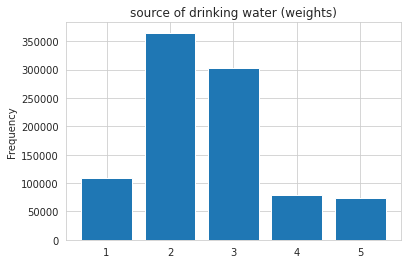

In [141]:
for col in ["source of drinking water (weights)"]:
    hist = df[col].plot.hist(bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8)
#     plt.xlim(0.5, 5.5)
    plt.title(col)
    plt.show()

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


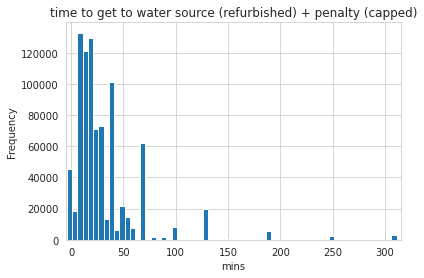

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


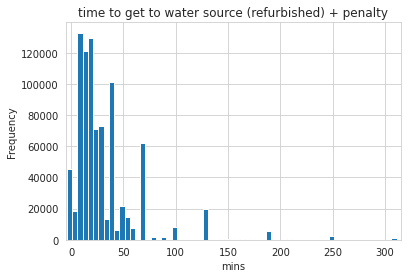

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


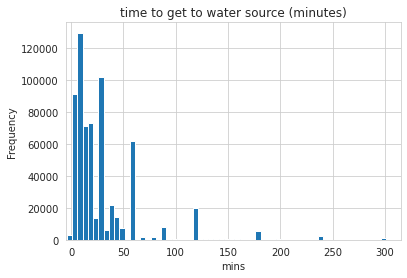

[-4, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311]


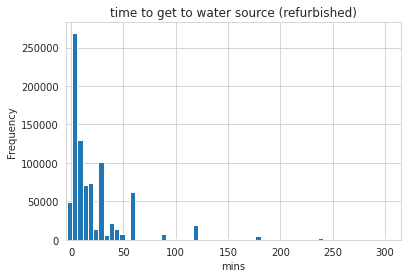

In [142]:
for col in ["time to get to water source (refurbished) + penalty (capped)", "time to get to water source (refurbished) + penalty",
            "time to get to water source (minutes)", "time to get to water source (refurbished)"]:
    sub_df = df[col]
    bins = list(range(-4, 315, 5))
    print(bins)
    hist = df[col].plot.hist(bins=bins)
    plt.xlim(-5, 315)
    plt.title(col)
    plt.xlabel("mins")
    plt.show()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


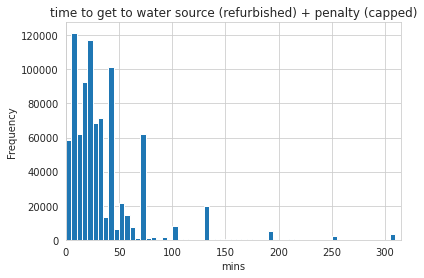

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


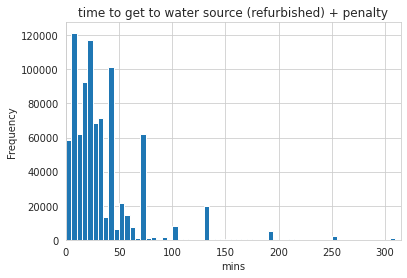

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


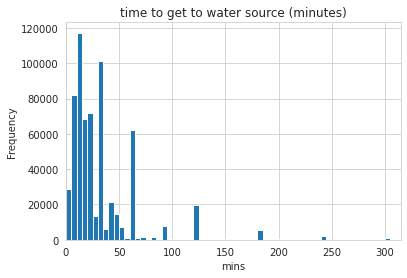

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310]


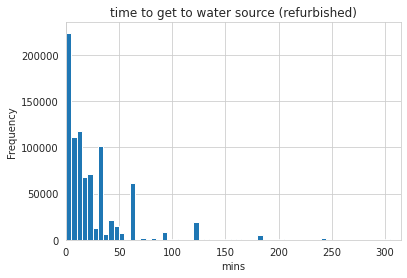

In [143]:
for col in ["time to get to water source (refurbished) + penalty (capped)", "time to get to water source (refurbished) + penalty",
            "time to get to water source (minutes)", "time to get to water source (refurbished)"]:
    bins = list(range(0, 315, 5))
    print(bins)
    hist = df[col].plot.hist(bins=bins)
    plt.xlim(0, 315)
    plt.title(col)
    plt.xlabel("mins")
    plt.show()

In [144]:
#create distance categories
df['distance categories'] = np.NaN
df['distance categories num'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories'])
        df['distance categories num'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num'])
df['distance categories 2'] = np.NaN
df['distance categories num 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        df['distance categories 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             df['distance categories 2'])
        df['distance categories num 2'] = np.where(df['time to get to water source (refurbished)'].between(v + 1,
                                replace_l[nr + 1]), -nr, df['distance categories num 2'])

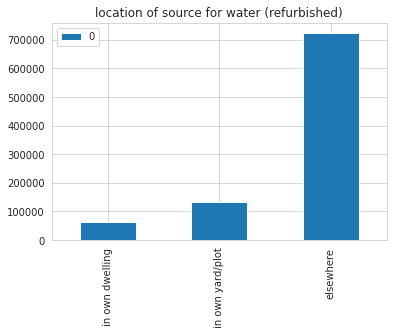

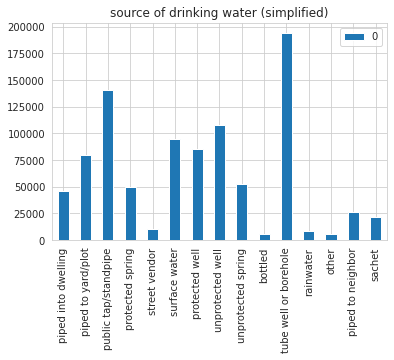

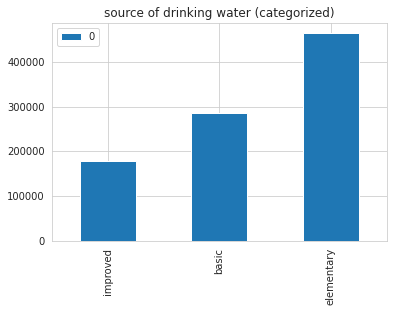

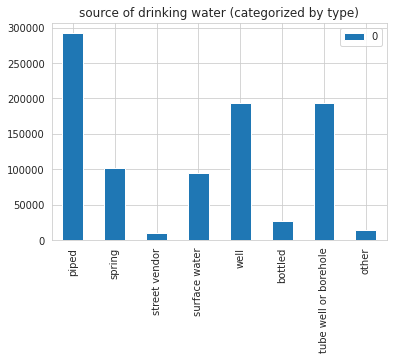

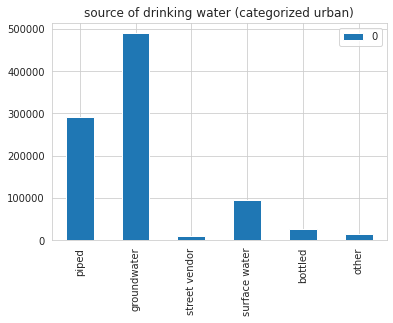

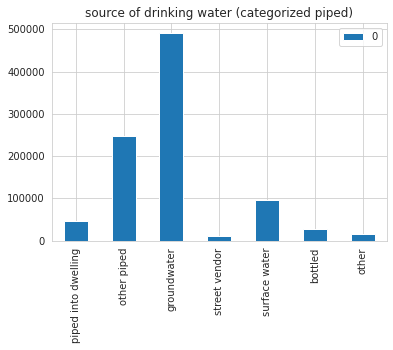

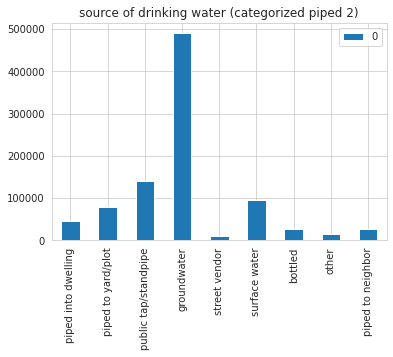

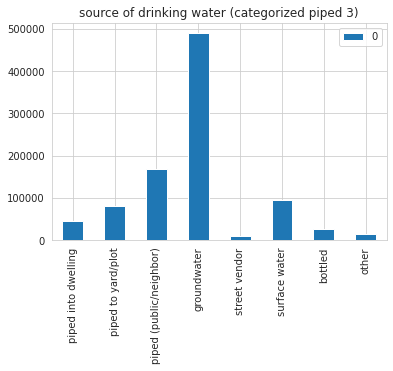

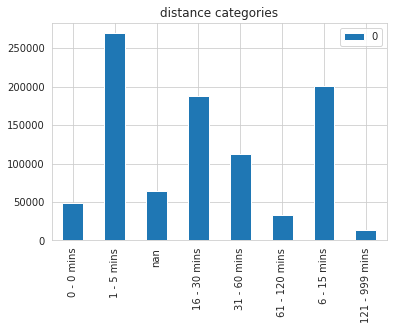

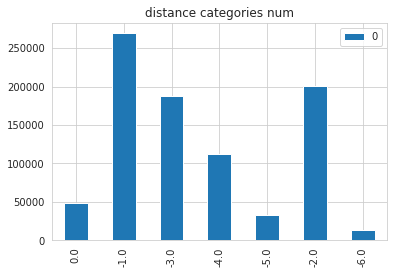

In [145]:
for col in ["location of source for water (refurbished)", "source of drinking water (simplified)",
           "source of drinking water (categorized)", "source of drinking water (categorized by type)",
           "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
           "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
           'distance categories', 'distance categories num']:
#     series = df[col].replace({np.NaN: None})
#     print(series)
    counts = Counter(df[col].dropna())
#     print(col, counts, type(counts))
    count_df = pd.DataFrame.from_dict(counts, orient='index')
    count_df.plot(kind='bar')
    plt.title(col)


In [146]:
df

,case identification,country code and phase,cluster number,household number,month of interview,year of interview,number of household members,region,source of drinking water,GEID,water shortages,time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,district,DHSID,URBAN_RURA,DHS survey ID,source of drinking water (simplified),source of drinking water (categorized by type),source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3),source of drinking water (categorized urban),source of drinking water (categorized),source of drinking water (weights),time to get to water source (refurbished),location of source for water (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories,distance categories num,distance categories 2,distance categories num 2
0,1 1,AO5,1.0000000000,1.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000,0.0000000000,in own dwelling,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0 - 0 mins,0.0000000000,0 - 5 mins,0.0000000000
1,1 2,AO5,1.0000000000,2.0000000000,3.0000000000,2011.0000000000,6.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000,0.0000000000,in own dwelling,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0 - 0 mins,0.0000000000,0 - 5 mins,0.0000000000
2,1 3,AO5,1.0000000000,3.0000000000,3.0000000000,2011.0000000000,9.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000,0.0000000000,in own dwelling,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0 - 0 mins,0.0000000000,0 - 5 mins,0.0000000000
3,1 4,AO5,1.0000000000,4.0000000000,3.0000000000,2011.0000000000,5.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000,0.0000000000,in own dwelling,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0 - 0 mins,0.0000000000,0 - 5 mins,0.0000000000
4,1 5,AO5,1.0000000000,5.0000000000,3.0000000000,2011.0000000000,3.0000000000,mesoendemica estavel,piped into dwelling,AOGE61FL,NaN,NaN,NaN,NaN,NaN,AO201100000001,U,AO2011,piped into dwelling,piped,piped into dwelling,piped into dwelling,piped into dwelling,piped,improved,5.0000000000,0.0000000000,in own dwelling,0.0000000000,5.0000000000,0.0000000000,0.0000000000,0 - 0 mins,0.0000000000,0 - 5 mins,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931373,400 25,ZW7,400.0000000000,25.0000000000,11.0000000000,2015.0000000000,5.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,NaN,in own yard/plot,yes,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0000000000,1.0000000000,in own yard/plot,5.0000000000,3.0000000000,6.0000000000,6.0000000000,1 - 5 mins,-1.0000000000,0 - 5 mins,0.0000000000
931374,400 26,ZW7,400.0000000000,26.0000000000,11.0000000000,2015.0000000000,2.0000000000,mashonaland east,protected well,ZWGE72FL,0.0000000000,NaN,in own yard/plot,no,NaN,ZW201500000400,R,ZW2015,protected well,well,groundwater,groundwater,groundwater,groundwater,basic,3.0000000000,1.0000000000,in own yard/plot,5.0000000000,3.0000000000,6.00

In [147]:
#create PCA
df2 = df
for n1, col_l in zip(['cat_distance', 'min', 'w_location_weighting', 'w_penalty'], 
                     [["source of drinking water (weights)", "distance categories num"],
             ["source of drinking water (weights)", 'time to get to water source (refurbished)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished)',
             'weighting (location)'],
            ["source of drinking water (weights)", 'time to get to water source (refurbished) + penalty']]): 
    for name, ind in {'urban': 'U', 'rural': 'R', 'all': 'a'}.items():
        ges_l = ["DHSID", "cluster number", "URBAN_RURA"] + col_l
        sub_df = df[ges_l].dropna()
        if name != 'all':
            sub_df = sub_df[sub_df["URBAN_RURA"] == ind]
        features = sub_df[col_l]
        col_n = 'PCA ' + n1 + ' ' + name
#         features["source of drinking water (weights)"] = -features["source of drinking water (weights)"]
#         features["distance categories num"] = -features["distance categories num"]
#         if "time to get to water source (refurbished)" in features.columns:
#             features["time to get to water source (refurbished)"] = -features["time to get to water source (refurbished)"]
#         print(name)
#         print('f', features)
        T = StandardScaler().fit_transform(features)
#         t2 = pd.DataFrame(T, columns=col_l)
#         print(t2)
        # apply the pca analysis
        pca_model = PCA(n_components=2)
        pca_model.fit(T)
        I = pca_model.transform(T)
#         print('I', I)
        sub_df[col_n] = I[:, 0]
        # print the varianz distribution of the principle components
        varianz_of_pcs = pca_model.explained_variance_ratio_
        print(name)
#         ax2 = sns.displot(sub_df[col_n], stat='probability')
#         print(sub_df)
        df2 = pd.merge(df2, sub_df[col_n], left_index=True, right_index=True, how='left')
        features['PCA'] = I[:,0]
        print(n1, name)
        corr_value = features.corr(method="pearson")
        for pc_i, pc_v in enumerate(varianz_of_pcs):
            print("Varianz of pc{}: {}".format(pc_i+1, pc_v))
#         pearson_corr = corr_value["Prediction"][1]
        print(corr_value.head())
        print('components', pca_model.components_)
        print('explained variance', pca_model.explained_variance_ratio_)
        print('singular values', pca_model.singular_values_)
        print('mean', pca_model.mean_)

        loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)

        fig = px.scatter(I, x=0, y=1)#, color=col_l)

        for i, feature in enumerate(col_l):
            fig.add_shape(
                type='line',
                x0=0, y0=0,
                x1=loadings[i, 0],
                y1=loadings[i, 1]
            )
            fig.add_annotation(
                x=loadings[i, 0],
                y=loadings[i, 1],
                ax=0, ay=0,
                xanchor="center",
                yanchor="bottom",
                text=feature,
            )
        fig.write_image(projects_p + '/imgs/pca/' + n1 + '_' + ind + '.png')
        # fig.show()
        
        
        
        
#         print('df', df)

# df2[col_l + ["PCA urban"]].dropna()
df = df2

urban


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance urban
Varianz of pc1: 0.7832089473724918
Varianz of pc2: 0.21679105262750828
                                    source of drinking water (weights)  distance categories num           PCA
source of drinking water (weights)                        1.0000000000             0.5664178947 -0.8849909307
distance categories num                                   0.5664178947             1.0000000000 -0.8849909307
PCA                                                      -0.8849909307            -0.8849909307  1.0000000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.78320895 0.21679105]
singular values [677.59450673 356.49359665]
mean [ 3.41319218e-17 -7.13667455e-17]
rural


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance rural
Varianz of pc1: 0.6320070990443275
Varianz of pc2: 0.3679929009556725
                                    source of drinking water (weights)  distance categories num          PCA
source of drinking water (weights)                        1.0000000000             0.2640141981 0.7949887415
distance categories num                                   0.2640141981             1.0000000000 0.7949887415
PCA                                                       0.7949887415             0.7949887415 1.0000000000
components [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.6320071 0.3679929]
singular values [843.45570543 643.6073904 ]
mean [ 1.28669914e-16 -8.21103925e-17]
all


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cat_distance all
Varianz of pc1: 0.7374270719890114
Varianz of pc2: 0.26257292801098864
                                    source of drinking water (weights)  distance categories num           PCA
source of drinking water (weights)                        1.0000000000             0.4748541440 -0.8587357405
distance categories num                                   0.4748541440             1.0000000000 -0.8587357405
PCA                                                      -0.8587357405            -0.8587357405  1.0000000000
components [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
explained variance [0.73742707 0.26257293]
singular values [1123.5565325  670.4406896]
mean [-1.19539631e-16  1.54338946e-16]
urban


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min urban
Varianz of pc1: 0.6226715906282464
Varianz of pc2: 0.37732840937175355
                                           source of drinking water (weights)  time to get to water source (refurbished)           PCA
source of drinking water (weights)                               1.0000000000                              -0.2453431813 -0.7890954256
time to get to water source (refurbished)                       -0.2453431813                               1.0000000000  0.7890954256
PCA                                                             -0.7890954256                               0.7890954256  1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.62267159 0.37732841]
singular values [604.17198313 470.31714279]
mean [3.41319218e-17 1.08601569e-17]
rural


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min rural
Varianz of pc1: 0.5667312191183338
Varianz of pc2: 0.4332687808816663
                                           source of drinking water (weights)  time to get to water source (refurbished)           PCA
source of drinking water (weights)                               1.0000000000                              -0.1334624382 -0.7528155279
time to get to water source (refurbished)                       -0.1334624382                               1.0000000000  0.7528155279
PCA                                                             -0.7528155279                               0.7528155279  1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.56673122 0.43326878]
singular values [798.71137674 698.36103604]
mean [1.28669914e-16 2.05528473e-17]
all


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



min all
Varianz of pc1: 0.6156050201054128
Varianz of pc2: 0.38439497989458704
                                           source of drinking water (weights)  time to get to water source (refurbished)           PCA
source of drinking water (weights)                               1.0000000000                              -0.2312100402 -0.7846050090
time to get to water source (refurbished)                       -0.2312100402                               1.0000000000  0.7846050090
PCA                                                             -0.7846050090                               0.7846050090  1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.61560502 0.38439498]
singular values [1026.56503241  811.19309306]
mean [-1.19539631e-16 -1.20701822e-17]
urban


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting urban
Varianz of pc1: 0.5972366364406544
Varianz of pc2: 0.2771742567729914
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)           PCA
source of drinking water (weights)                               1.0000000000                              -0.2454947847          0.6225535698 -0.8538600171
time to get to water source (refurbished)                       -0.2454947847                               1.0000000000         -0.2719621822  0.5616888446
weighting (location)                                             0.6225535698                              -0.2719621822          1.0000000000 -0.8643718079
PCA                                                             -0.8538600171                               0.5616888446         -0.8643718079  1.0000000000
components [[-0.63790033  0.41962558 -0.64575347]
 [ 0.32308351  0.90697274  0.27021749]]
explained variance [0.597236

/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting rural
Varianz of pc1: 0.498073422157186
Varianz of pc2: 0.29581981980602434
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)           PCA
source of drinking water (weights)                               1.0000000000                              -0.1334609809          0.3707783414 -0.7465691866
time to get to water source (refurbished)                       -0.1334609809                               1.0000000000         -0.2145013221  0.5479114005
weighting (location)                                             0.3707783414                              -0.2145013221          1.0000000000 -0.7979021326
PCA                                                             -0.7465691866                               0.5479114005         -0.7979021326  1.0000000000
components [[-0.61074898  0.44823217 -0.65274314]
 [ 0.45187782  0.87423776  0.177524  ]]
explained variance [0.498073

/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_location_weighting all
Varianz of pc1: 0.5823337143806337
Varianz of pc2: 0.2778858166477019
                                           source of drinking water (weights)  time to get to water source (refurbished)  weighting (location)           PCA
source of drinking water (weights)                               1.0000000000                              -0.2313342473          0.5791357353 -0.8363375208
time to get to water source (refurbished)                       -0.2313342473                               1.0000000000         -0.2692744751  0.5663186531
weighting (location)                                             0.5791357353                              -0.2692744751          1.0000000000 -0.8525396633
PCA                                                             -0.8363375208                               0.5663186531         -0.8525396633  1.0000000000
components [[-0.63275413  0.42846393 -0.6450123 ]
 [ 0.34422664  0.90178035  0.26134312]]
explained variance [0.58233371

/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty urban
Varianz of pc1: 0.6507354195181035
Varianz of pc2: 0.3492645804818963
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty           PCA
source of drinking water (weights)                                        1.0000000000                                      -0.3014708390   -0.8066817337
time to get to water source (refurbished) + pen...                       -0.3014708390                                       1.0000000000    0.8066817337
PCA                                                                      -0.8066817337                                       0.8066817337    1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.65073542 0.34926458]
singular values [617.49576679 452.38587289]
mean [-1.05546920e-16  4.34604963e-17]
rural


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty rural
Varianz of pc1: 0.5749325306900279
Varianz of pc2: 0.42506746930997213
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty           PCA
source of drinking water (weights)                                        1.0000000000                                      -0.1498650614   -0.7582430552
time to get to water source (refurbished) + pen...                       -0.1498650614                                       1.0000000000    0.7582430552
PCA                                                                      -0.7582430552                                       0.7582430552    1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.57493253 0.42506747]
singular values [804.15670886 691.45064002]
mean [1.81354629e-16 8.42969265e-17]
all


/tmp/ipykernel_1263240/3854318103.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



w_penalty all
Varianz of pc1: 0.6333283794927358
Varianz of pc2: 0.3666716205072642
                                                    source of drinking water (weights)  time to get to water source (refurbished) + penalty           PCA
source of drinking water (weights)                                        1.0000000000                                      -0.2666567590   -0.7958193133
time to get to water source (refurbished) + pen...                       -0.2666567590                                       1.0000000000    0.7958193133
PCA                                                                      -0.7958193133                                       0.7958193133    1.0000000000
components [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
explained variance [0.63332838 0.36667162]
singular values [1040.88967971  792.00673903]
mean [-1.36100488e-16  2.88748350e-17]


PCA cat_distance urban : -0.8849909306724472
PCA cat_distance urban -4.080514685620085 -1.5514509891695095e-17 2.0201929471346505


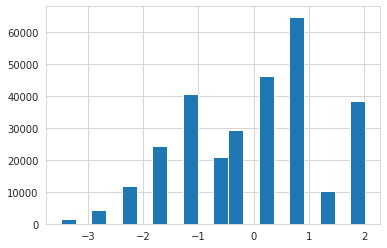

PCA cat_distance rural : 0.7949887414576103
PCA cat_distance rural -2.9731871281218454 6.4132963371521274e-18 3.7295071921375116


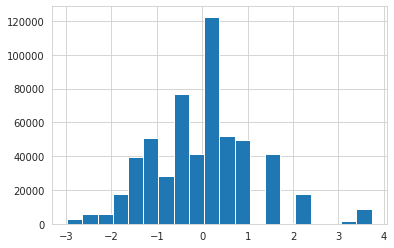

PCA cat_distance all : -0.8587357404865394
PCA cat_distance all -3.0780264390586427 9.563170469669255e-18 2.7724741742501773


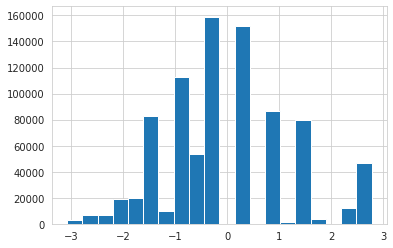

PCA min urban : -0.7890954255527406
PCA min urban -19.41877430582619 1.0860156924186567e-17 1.3551914996721035


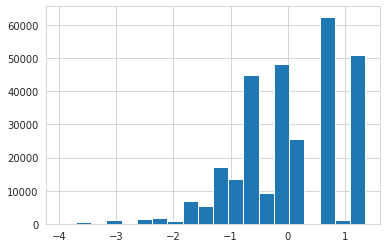

PCA min rural : -0.752815527947133
PCA min rural -14.931668218636597 5.133161989539478e-17 2.787494651883804


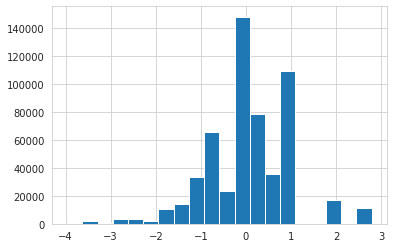

PCA min all : -0.7846050089729292
PCA min all -15.77829347623755 3.400238389215735e-17 2.000965719824764


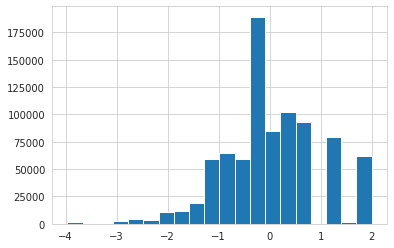

PCA w_location_weighting urban : -0.8538600170830026
PCA w_location_weighting urban -12.482314499359514 -4.346049630114649e-17 2.3688193845081833


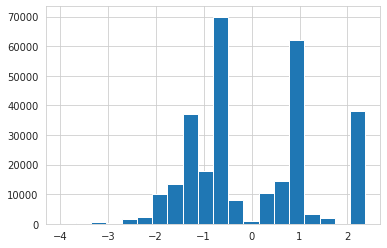

PCA w_location_weighting rural : -0.7465691866013707
PCA w_location_weighting rural -9.936342941238035 6.09484972475617e-17 5.074859151941


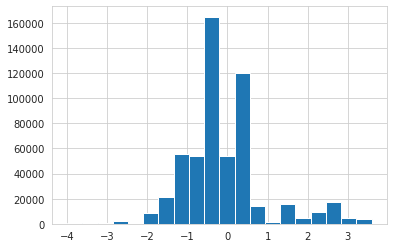

PCA w_location_weighting all : -0.8363375208305135
PCA w_location_weighting all -10.197725965914433 4.253140254011119e-17 3.51035719249735


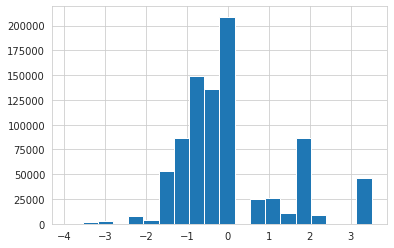

PCA w_penalty urban : -0.8066817337203812
PCA w_penalty urban -18.881983153488612 -6.208642328735213e-18 1.4846033098322946


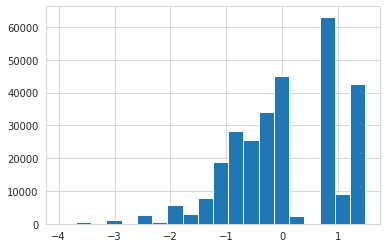

PCA w_penalty rural : -0.7582430551545338
PCA w_penalty rural -14.780427367791829 4.194631236772488e-17 2.927249566266094


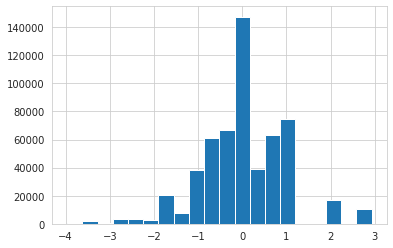

PCA w_penalty all : -0.795819313344884
PCA w_penalty all -15.49208156156021 -1.3822705825536137e-17 2.1318100832332334


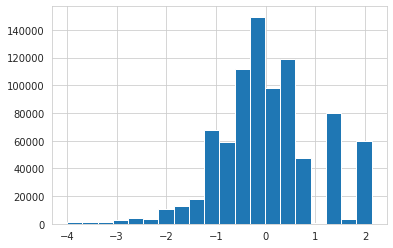

In [148]:
for col in df.columns:
    if "PCA" in col:
        r2 = df[[col, "source of drinking water (weights)"]].corr().iloc[1,0]
        print(col, ':', r2)
        if r2 < 0:
            df[col] = df[col] * (-1)
        sub_df = df[col]
        #drop values <-4 and >4 for sub df
        sub_df = sub_df[(sub_df > -4) & (sub_df < 4)]
        sub_df.hist(bins=20)
        print(col, df[col].min(), df[col].mean(), df[col].max())
        plt.show()


In [149]:
#NaN error
df2 = df[["PCA w_location_weighting urban", 'water shortages']].dropna()
print(scipy.stats.pointbiserialr(df2["PCA w_location_weighting urban"], df2['water shortages']))

PointbiserialrResult(correlation=0.08309894260263859, pvalue=4.5570402445820585e-112)


In [150]:
cluster_df = df.groupby('DHSID').mean()
cluster_df

,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all
DHSID,,,,,,,,,,,,,,,,,,,,,,,,,,,
AO201100000001,1.0000000000,18.7222222222,2.9722222222,2011.0000000000,5.7500000000,NaN,NaN,4.8611111111,0.1388888889,0.6944444444,4.7222222222,0.8333333333,0.8333333333,-0.1388888889,0.0000000000,1.8494395986,NaN,2.6057841232,1.2637796242,NaN,1.9048534425,2.1665540215,NaN,3.2752293304,1.3796954302,NaN,2.0243811254
AO201100000002,2.0000000000,20.3437500000,3.0000000000,2011.0000000000,5.8125000000,NaN,NaN,4.5937500000,0.3548387097,2.0312500000,4.1875000000,2.1290322581,2.1290322581,-0.3548387097,0.0000000000,1.5839456825,NaN,2.3466079793,1.1216489018,NaN,1.7554143533,1.8520640055,NaN,2.9096434286,1.2165805981,NaN,1.8573464233
AO201100000003,3.0000000000,19.1944444444,2.0000000000,2011.0000000000,5.3611111111,NaN,NaN,3.0833333333,1.0000000000,9.5833333333,1.1666666667,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871
AO201100000004,4.0000000000,19.3142857143,2.0000000000,2011.0000000000,4.8571428571,NaN,NaN,3.0571428571,1.0000000000,9.7142857143,1.1142857143,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871
AO201100000005,5.0000000000,19.0000000000,2.4864864865,2011.0000000000,5.4594594595,NaN,NaN,3.8108108108,0.9655172414,5.9459459459,2.6216216216,5.7931034483,5.7931034483,-0.9655172414,0.0000000000,0.8331627724,NaN,1.6136909227,0.7197213588,NaN,1.3328196819,0.9627263783,NaN,1.8758131578,0.7553126709,NaN,1.3849936042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000396,396.0000000000,14.7500000000,9.5416666667,2015.0000000000,3.5416666667,0.2500000000,13.0714285714,2.7500000000,8.0416666667,7.9166666667,1.8333333333,15.9583333333,15.9583333333,-1.4166666667,-0.4166666667,-0.2530899682,NaN,0.5095233230,-0.2429447042,NaN,0.3469155610,-0.3982187599,NaN,0.3616153687,-0.2630311800,NaN,0.3511455831
ZW201500000397,397.0000000000,14.2000000000,10.0000000000,2015.0000000000,3.9200000000,0.2000000000,17.5000000000,2.9200000000,4.9600000000,6.2000000000,2.5200000000,11.1600000000,11.1600000000,-1.3200000000,-0.3200000000,NaN,1.2300857394,0.6750582836,NaN,0.9322991087,0.5133378871,NaN,1.6329693858,0.8659318879,NaN,0.9760532476,0.5446013225
ZW201500000398,398.0000000000,15.2857142857,9.0000000000,2015.0000000000,4.7142857143,0.1428571429,27.0370370370,1.8928571429,26.1071428571,9.8214285714,1.0714285714,35.9285714286,35.9285714286,-2.7142857143,-1.7142857143,NaN,-0.4108617518,-0.7504043510,NaN,-0.2809821316,-0.5345360266,NaN,-0.4227666063,-0.7504607430,NaN,-0.2899429136,-0.5550058666


In [151]:
cluster_dfb = pd.merge(cluster_df, locations_df, how="left", on="DHSID")
cluster_dfb[cluster_dfb["LATNUM"].notna()]

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name
0,AO201100000001,1.0000000000,18.7222222222,2.9722222222,2011.0000000000,5.7500000000,NaN,NaN,4.8611111111,0.1388888889,0.6944444444,4.7222222222,0.8333333333,0.8333333333,-0.1388888889,0.0000000000,1.8494395986,NaN,2.6057841232,1.2637796242,NaN,1.9048534425,2.1665540215,NaN,3.2752293304,1.3796954302,NaN,2.0243811254,2011.0000000000,U,-12.3502570000,13.5349220000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif
1,AO201100000002,2.0000000000,20.3437500000,3.0000000000,2011.0000000000,5.8125000000,NaN,NaN,4.5937500000,0.3548387097,2.0312500000,4.1875000000,2.1290322581,2.1290322581,-0.3548387097,0.0000000000,1.5839456825,NaN,2.3466079793,1.1216489018,NaN,1.7554143533,1.8520640055,NaN,2.9096434286,1.2165805981,NaN,1.8573464233,2011.0000000000,U,-12.3608650000,13.5514940000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif
2,AO201100000003,3.0000000000,19.1944444444,2.0000000000,2011.0000000000,5.3611111111,NaN,NaN,3.0833333333,1.0000000000,9.5833333333,1.1666666667,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871,2011.0000000000,U,-12.6134210000,13.4130850000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif
3,AO201100000004,4.0000000000,19.3142857143,2.0000000000,2011.0000000000,4.8571428571,NaN,NaN,3.0571428571,1.0000000000,9.7142857143,1.1142857143,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871,2011.0000000000,U,-12.5814540000,13.3977110000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000004.tif
4,AO201100000005,5.0000000000,19.0000000000,2.4864864865,2011.0000000000,5.4594594595,NaN,NaN,3.8108108108,0.9655172414,5.9459459459,2.6216216216,5.7931034483,5.7931034483,-0.9655172414,0.0000000000,0.8331627724,NaN,1.6136909227,0.7197213588,NaN,1.3328196819,0.9627263783,NaN,1.8758131578,0.7553126709,NaN,1.3849936042,2011.0000000000,U,-12.5781350000,13.4187480000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000005.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36127,ZW201500000396,396.0000000000,14.7500000000,9.5416666667,2015.0000000000,3.5416666667,0.2500000000,13.0714285714,2.7500000000,8.0416666667,7.9166666667,1.8333333333,15.9583333333,15.9583333333,-1.4166666667,-0.4166666667,-0.2530899682,NaN,0.5095233230,-0.2429447042,NaN,0.3469155610,-0.3982187599,NaN,0.3616153687,-0.2630311800,NaN,0.3511455831,2015.0000000000,U,-17.9152880000,31.1561150000,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif
36128,ZW201500000397,397.0000000000,14.2000000000,10.0000000000,2015.0000000000,3.9200000000,0.2000000000,17.5000000000,2.9200000000,4.9600000000,6.2000000000,2.5200000000,11.1600000000,11.1600000000,-1.3200000000,-0.3200000000,NaN,1.2300857394,0.6750582836,NaN,0.9322991087,0.5133378871,NaN,1.6329693858,0.8659318879,NaN,0.9760532476,0.5446013225,2015.0000000000,R,-18.3795010000,31.8722870000,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif
36129,ZW201500000398,398.0000000000,15.2857142857,9.0000000000,2015.0000

In [152]:
cols = [c for c in df.columns if "PCA w_lo" in c or "(weights)" in c] + ["time to get to water source (refurbished)", "weighting (location)"]
print(cols)
corr_df = df[cols]

# create a correlation matrix
corr_matrix = corr_df.corr()

# print the correlation matrix
print(corr_matrix)

['source of drinking water (weights)', 'PCA w_location_weighting urban', 'PCA w_location_weighting rural', 'PCA w_location_weighting all', 'time to get to water source (refurbished)', 'weighting (location)']
                                           source of drinking water (weights)  PCA w_location_weighting urban  PCA w_location_weighting rural  PCA w_location_weighting all  time to get to water source (refurbished)  weighting (location)
source of drinking water (weights)                               1.0000000000                    0.8538600171                    0.7465691866                  0.8363375208                              -0.2306256496          0.5555593131
PCA w_location_weighting urban                                   0.8538600171                    1.0000000000                             NaN                  0.9968689647                              -0.5616888446          0.8643718079
PCA w_location_weighting rural                                   0.7465691866    

In [153]:
# cluster_dfc1 = df.groupby('DHSID').mean()
# cluster_dfc2 = pd.merge(cluster_dfc1, locations_df, how="left", left_on="alt_DHSID", right_on="DHSID")
# cluster_dfc2

In [154]:
join_df = pd.DataFrame(df[["DHSID"]].value_counts(dropna=False)).reset_index()
join_df.rename(columns={0: "households"}, inplace=True)
join_df

,DHSID,households
0,NG201300000370,45
1,NG201300000494,45
2,NG201300000451,45
3,NG201300000455,45
4,NG201300000456,45
...,...,...
36127,GN201800000334,5
36128,ET201600000039,5
36129,SL201900000510,4
36130,ZM201300000574,4


In [155]:
cluster_df2 = pd.merge(cluster_dfb, join_df, on="DHSID")
cluster_df2

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households
0,AO201100000001,1.0000000000,18.7222222222,2.9722222222,2011.0000000000,5.7500000000,NaN,NaN,4.8611111111,0.1388888889,0.6944444444,4.7222222222,0.8333333333,0.8333333333,-0.1388888889,0.0000000000,1.8494395986,NaN,2.6057841232,1.2637796242,NaN,1.9048534425,2.1665540215,NaN,3.2752293304,1.3796954302,NaN,2.0243811254,2011.0000000000,U,-12.3502570000,13.5349220000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif,36
1,AO201100000002,2.0000000000,20.3437500000,3.0000000000,2011.0000000000,5.8125000000,NaN,NaN,4.5937500000,0.3548387097,2.0312500000,4.1875000000,2.1290322581,2.1290322581,-0.3548387097,0.0000000000,1.5839456825,NaN,2.3466079793,1.1216489018,NaN,1.7554143533,1.8520640055,NaN,2.9096434286,1.2165805981,NaN,1.8573464233,2011.0000000000,U,-12.3608650000,13.5514940000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif,32
2,AO201100000003,3.0000000000,19.1944444444,2.0000000000,2011.0000000000,5.3611111111,NaN,NaN,3.0833333333,1.0000000000,9.5833333333,1.1666666667,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871,2011.0000000000,U,-12.6134210000,13.4130850000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif,36
3,AO201100000004,4.0000000000,19.3142857143,2.0000000000,2011.0000000000,4.8571428571,NaN,NaN,3.0571428571,1.0000000000,9.7142857143,1.1142857143,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871,2011.0000000000,U,-12.5814540000,13.3977110000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000004.tif,35
4,AO201100000005,5.0000000000,19.0000000000,2.4864864865,2011.0000000000,5.4594594595,NaN,NaN,3.8108108108,0.9655172414,5.9459459459,2.6216216216,5.7931034483,5.7931034483,-0.9655172414,0.0000000000,0.8331627724,NaN,1.6136909227,0.7197213588,NaN,1.3328196819,0.9627263783,NaN,1.8758131578,0.7553126709,NaN,1.3849936042,2011.0000000000,U,-12.5781350000,13.4187480000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000005.tif,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36127,ZW201500000396,396.0000000000,14.7500000000,9.5416666667,2015.0000000000,3.5416666667,0.2500000000,13.0714285714,2.7500000000,8.0416666667,7.9166666667,1.8333333333,15.9583333333,15.9583333333,-1.4166666667,-0.4166666667,-0.2530899682,NaN,0.5095233230,-0.2429447042,NaN,0.3469155610,-0.3982187599,NaN,0.3616153687,-0.2630311800,NaN,0.3511455831,2015.0000000000,U,-17.9152880000,31.1561150000,Zimbabwe,Harare,Harare,ZWGE72FL,ZWGE72FL00000396.tif,24
36128,ZW201500000397,397.0000000000,14.2000000000,10.0000000000,2015.0000000000,3.9200000000,0.2000000000,17.5000000000,2.9200000000,4.9600000000,6.2000000000,2.5200000000,11.1600000000,11.1600000000,-1.3200000000,-0.3200000000,NaN,1.2300857394,0.6750582836,NaN,0.9322991087,0.5133378871,NaN,1.6329693858,0.8659318879,NaN,0.9760532476,0.5446013225,2015.0000000000,R,-18.3795010000,31.8722870000,Zimbabwe,Manicaland,Makoni,ZWGE72FL,ZWGE72FL00000397.tif,25
36129,ZW201500000398,398.0000000000,

In [156]:
#Create Stds
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df.rename(columns=replace_d)
stddev_df = df.groupby('DHSID').std()
stddev_df = stddev_df.drop(columns=
                           ["cluster number", "household number", "year of interview", "number of household members"])
replace_d = {c: 'Std Deviation: '+ c for c in stddev_df.columns}
stddev_df =stddev_df.rename(columns=replace_d)
stddev_df

,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all
DHSID,,,,,,,,,,,,,,,,,,,,,,,
AO201100000001,0.1666666667,NaN,NaN,0.3507361872,0.3507361872,1.7536809360,0.7014723744,2.1044171232,2.1044171232,0.3507361872,0.0000000000,0.4312035246,NaN,0.4209424773,0.2308424591,NaN,0.2427123865,0.5107808320,NaN,0.5937685191,0.2649239258,NaN,0.2712904060
AO201100000002,0.0000000000,NaN,NaN,0.5599179087,0.4863734571,2.7995895436,1.1198358175,2.9182407427,2.9182407427,0.4863734571,0.0000000000,0.5979592544,NaN,0.5837300381,0.3201142311,NaN,0.3365745161,0.7083108277,NaN,0.8233916484,0.3673757382,NaN,0.3762042739
AO201100000003,0.0000000000,NaN,NaN,0.2803059553,0.0000000000,1.4015297765,0.5606119106,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000
AO201100000004,0.0000000000,NaN,NaN,0.2355041080,0.0000000000,1.1775205399,0.4710082160,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000
AO201100000005,0.5067117097,NaN,NaN,0.4617501632,0.1856953382,2.3087508160,0.9235003264,1.1141720291,1.1141720291,0.1856953382,0.0000000000,0.2282983258,NaN,0.2228656709,0.1222182657,NaN,0.1285027332,0.2704300919,NaN,0.3143674647,0.1402625101,NaN,0.1436332079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW201500000396,0.5089773777,0.4423258685,17.5607266615,0.4423258685,14.5347534541,2.5180507759,1.0072203104,15.7548589238,15.7548589238,0.9286112430,0.9286112430,0.6306596541,NaN,0.5849962414,0.4235789012,NaN,0.4000838243,0.6159936046,NaN,0.6999211624,0.4361337439,NaN,0.4118769698
ZW201500000397,0.0000000000,0.4082482905,9.8742088291,0.6403124237,8.4876380696,2.1794494718,0.8717797887,10.3990384171,10.3990384171,0.6271629241,0.6271629241,NaN,0.7134823020,0.6041793561,NaN,0.5926656617,0.4853097047,NaN,0.9539837369,0.7380152621,NaN,0.6063553722,0.5007033701
ZW201500000398,0.0000000000,0.3563483225,22.6706884315,0.6288900107,22.7845615140,0.9449111825,0.3779644730,23.0071302497,23.0071302497,1.1174422798,1.1174422798,NaN,0.9306390616,0.8235126205,NaN,0.7285948206,0.6471460125,NaN,0.7263072990,0.6028533691,NaN,0.7309772907,0.6464630279


In [157]:
cluster_df5 = pd.merge(cluster_df2, stddev_df, how="left", on=['DHSID'])
cluster_df5

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all
0,AO201100000001,1.0000000000,18.7222222222,2.9722222222,2011.0000000000,5.7500000000,NaN,NaN,4.8611111111,0.1388888889,0.6944444444,4.7222222222,0.8333333333,0.8333333333,-0.1388888889,0.0000000000,1.8494395986,NaN,2.6057841232,1.2637796242,NaN,1.9048534425,2.1665540215,NaN,3.2752293304,1.3796954302,NaN,2.0243811254,2011.0000000000,U,-12.3502570000,13.5349220000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000001.tif,36,0.1666666667,NaN,NaN,0.3507361872,0.3507361872,1.7536809360,0.7014723744,2.1044171232,2.1044171232,0.3507361872,0.0000000000,0.4312035246,NaN,0.4209424773,0.2308424591,NaN,0.2427123865,0.5107808320,NaN,0.5937685191,0.2649239258,NaN,0.2712904060
1,AO201100000002,2.0000000000,20.3437500000,3.0000000000,2011.0000000000,5.8125000000,NaN,NaN,4.5937500000,0.3548387097,2.0312500000,4.1875000000,2.1290322581,2.1290322581,-0.3548387097,0.0000000000,1.5839456825,NaN,2.3466079793,1.1216489018,NaN,1.7554143533,1.8520640055,NaN,2.9096434286,1.2165805981,NaN,1.8573464233,2011.0000000000,U,-12.3608650000,13.5514940000,Angola,Benguela,Lobito,AOGE61FL,AOGE61FL00000002.tif,32,0.0000000000,NaN,NaN,0.5599179087,0.4863734571,2.7995895436,1.1198358175,2.9182407427,2.9182407427,0.4863734571,0.0000000000,0.5979592544,NaN,0.5837300381,0.3201142311,NaN,0.3365745161,0.7083108277,NaN,0.8233916484,0.3673757382,NaN,0.3762042739
2,AO201100000003,3.0000000000,19.1944444444,2.0000000000,2011.0000000000,5.3611111111,NaN,NaN,3.0833333333,1.0000000000,9.5833333333,1.1666666667,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0.9125087710,NaN,1.8174365852,0.7292665767,NaN,1.3583215871,2011.0000000000,U,-12.6134210000,13.4130850000,Angola,Benguela,Benguela,AOGE61FL,AOGE61FL00000003.tif,36,0.0000000000,NaN,NaN,0.2803059553,0.0000000000,1.4015297765,0.5606119106,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000,0.0000000000,NaN,0.0000000000
3,AO201100000004,4.0000000000,19.3142857143,2.0000000000,2011.0000000000,4.8571428571,NaN,NaN,3.0571428571,1.0000000000,9.7142857143,1.1142857143,6.0000000000,6.0000000000,-1.0000000000,0.0000000000,0.7907688376,NaN,1.5723058065,0.6970259966,NaN,1.3089573234,0

In [158]:
for col in ["source of drinking water (simplified)", "source of drinking water (categorized by type)", 
            "source of drinking water (categorized urban)", "source of drinking water (categorized piped)",
            "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)"]:
    count_df = pd.DataFrame(df.groupby("DHSID")[col].value_counts())
    count_df.columns = [col + ': counts']
    count_df = count_df.reset_index()
    count_df2 = count_df.pivot(index='DHSID', columns=col, 
                         values=col + ': counts')
    count_df2 = count_df2.fillna(0)
    count_df2 = count_df2.rename(columns={c: col + ': ' + str(c) for c in count_df2.columns})
    # count_df2 = count_df2.reset_index()
    # count_df
    cluster_df5 = pd.merge(cluster_df5, count_df2, how="outer", on=['DHSID'])

In [159]:
cluster_df5

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwelling,sou

source of drinking water (simplified):
                DHSID URBAN_RURA  source of drinking water (simplified): bottled  source of drinking water (simplified): other  source of drinking water (simplified): piped into dwelling  source of drinking water (simplified): piped to neighbor  source of drinking water (simplified): piped to yard/plot  source of drinking water (simplified): protected spring  source of drinking water (simplified): protected well  source of drinking water (simplified): public tap/standpipe  source of drinking water (simplified): rainwater  source of drinking water (simplified): sachet  source of drinking water (simplified): street vendor  source of drinking water (simplified): surface water  source of drinking water (simplified): tube well or borehole  source of drinking water (simplified): unprotected spring  source of drinking water (simplified): unprotected well
0      AO201100000001          U                                    0.0000000000                     

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized by type):
                DHSID URBAN_RURA  source of drinking water (categorized by type): bottled  source of drinking water (categorized by type): other  source of drinking water (categorized by type): piped  source of drinking water (categorized by type): spring  source of drinking water (categorized by type): street vendor  source of drinking water (categorized by type): surface water  source of drinking water (categorized by type): tube well or borehole  source of drinking water (categorized by type): well
0      AO201100000001          U                                       0.0000000000                                             0.0000000000                                          36.0000000000                                           0.0000000000                                            0.0000000000                                                   0.0000000000                                                   0.0000000000             

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized urban):
                DHSID URBAN_RURA  source of drinking water (categorized urban): bottled  source of drinking water (categorized urban): groundwater  source of drinking water (categorized urban): other  source of drinking water (categorized urban): piped  source of drinking water (categorized urban): street vendor  source of drinking water (categorized urban): surface water
0      AO201100000001          U                                       0.0000000000                                           0.0000000000                                               0.0000000000                                        36.0000000000                                         0.0000000000                                                 0.0000000000          
1      AO201100000002          U                                       0.0000000000                                           0.0000000000                                               0.0000000000       

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized):
                DHSID URBAN_RURA  source of drinking water (categorized): basic  source of drinking water (categorized): elementary  source of drinking water (categorized): improved
0      AO201100000001          U                                   0.0000000000                                       0.0000000000                                      36.0000000000
1      AO201100000002          U                                   1.0000000000                                       0.0000000000                                      31.0000000000
2      AO201100000003          U                                  33.0000000000                                       0.0000000000                                       3.0000000000
3      AO201100000004          U                                  33.0000000000                                       0.0000000000                                       2.0000000000
4      AO201100000005          U                  

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (weights):
                DHSID URBAN_RURA  source of drinking water (weights): 1.0  source of drinking water (weights): 2.0  source of drinking water (weights): 3.0  source of drinking water (weights): 4.0  source of drinking water (weights): 5.0
0      AO201100000001          U                             0.0000000000                             0.0000000000                             0.0000000000                             5.0000000000                            31.0000000000
1      AO201100000002          U                             0.0000000000                             0.0000000000                             1.0000000000                            11.0000000000                            20.0000000000
2      AO201100000003          U                             0.0000000000                             0.0000000000                            33.0000000000                             3.0000000000                             0.0000000000
3      AO201

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



location of source for water (refurbished):
                DHSID URBAN_RURA  location of source for water (refurbished): elsewhere  location of source for water (refurbished): in own dwelling  location of source for water (refurbished): in own yard/plot
0      AO201100000001          U                                       0.0000000000                                          31.0000000000                                                 5.0000000000           
1      AO201100000002          U                                       1.0000000000                                          20.0000000000                                                11.0000000000           
2      AO201100000003          U                                      33.0000000000                                           0.0000000000                                                 3.0000000000           
3      AO201100000004          U                                      33.0000000000                             

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized piped):
                DHSID URBAN_RURA  source of drinking water (categorized piped): bottled  source of drinking water (categorized piped): groundwater  source of drinking water (categorized piped): other  source of drinking water (categorized piped): other piped  source of drinking water (categorized piped): piped into dwelling  source of drinking water (categorized piped): street vendor  source of drinking water (categorized piped): surface water
0      AO201100000001          U                                       0.0000000000                                           0.0000000000                                               0.0000000000                                         5.0000000000                                              31.0000000000                                                       0.0000000000                                                 0.0000000000          
1      AO201100000002          U                          

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized piped 2):
                DHSID URBAN_RURA  source of drinking water (categorized piped 2): bottled  source of drinking water (categorized piped 2): groundwater  source of drinking water (categorized piped 2): other  source of drinking water (categorized piped 2): piped into dwelling  source of drinking water (categorized piped 2): piped to neighbor  source of drinking water (categorized piped 2): piped to yard/plot  source of drinking water (categorized piped 2): public tap/standpipe  source of drinking water (categorized piped 2): street vendor  source of drinking water (categorized piped 2): surface water
0      AO201100000001          U                                       0.0000000000                                             0.0000000000                                                 0.0000000000                                          31.0000000000                                                         0.0000000000                     

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



source of drinking water (categorized piped 3):
                DHSID URBAN_RURA  source of drinking water (categorized piped 3): bottled  source of drinking water (categorized piped 3): groundwater  source of drinking water (categorized piped 3): other  source of drinking water (categorized piped 3): piped (public/neighbor)  source of drinking water (categorized piped 3): piped into dwelling  source of drinking water (categorized piped 3): piped to yard/plot  source of drinking water (categorized piped 3): street vendor  source of drinking water (categorized piped 3): surface water
0      AO201100000001          U                                       0.0000000000                                             0.0000000000                                                 0.0000000000                                           0.0000000000                                                            31.0000000000                                                         5.0000000000            

/tmp/ipykernel_1263240/773105526.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/tmp/ipykernel_1263240/773105526.py:27: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwelling,sou

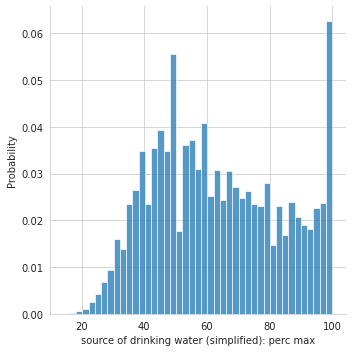

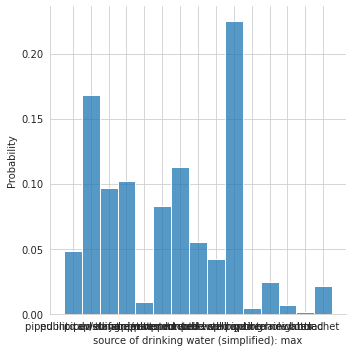

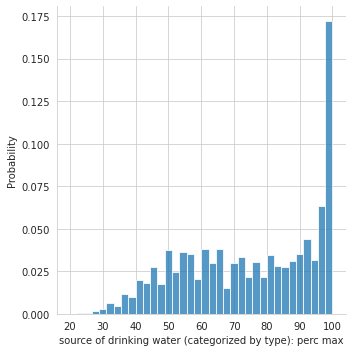

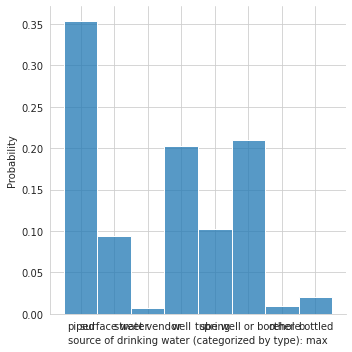

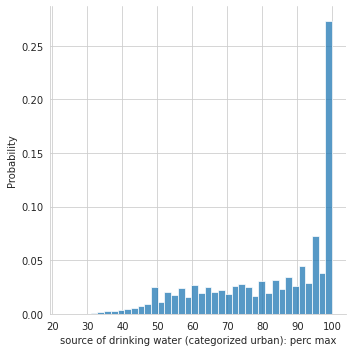

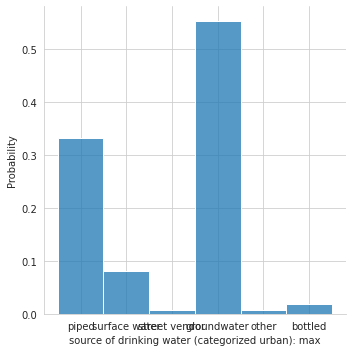

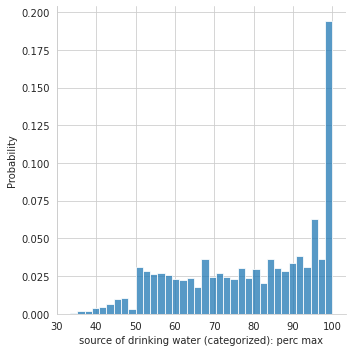

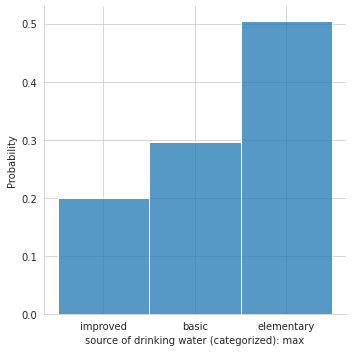

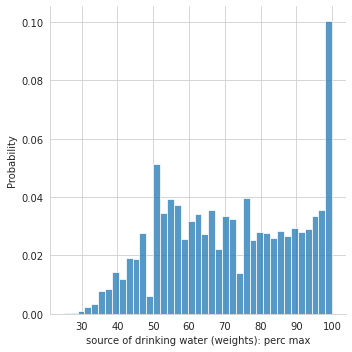

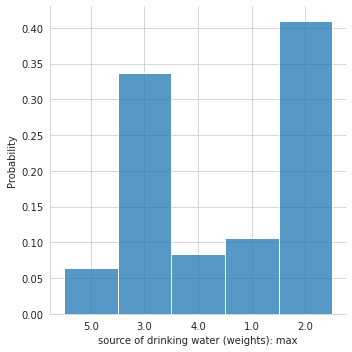

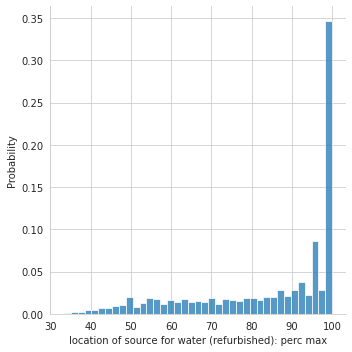

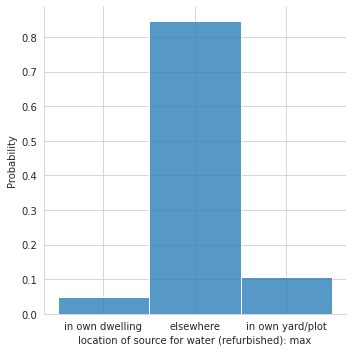

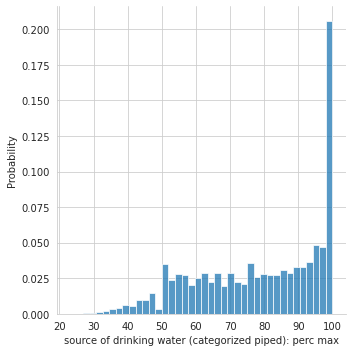

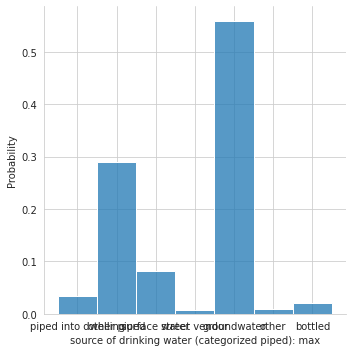

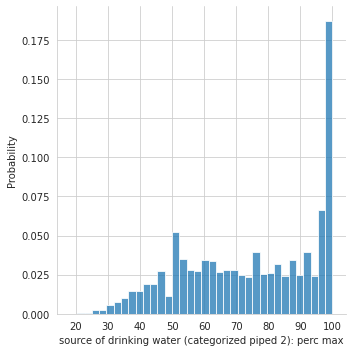

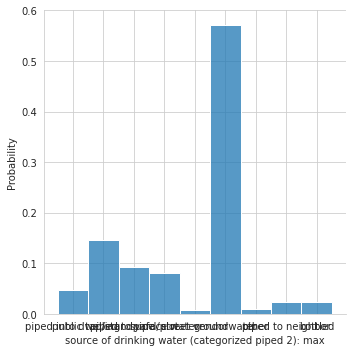

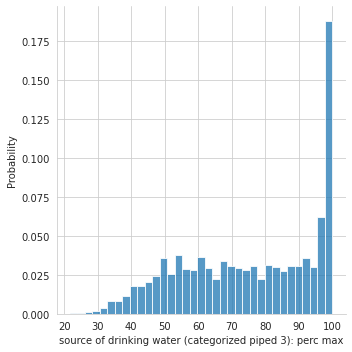

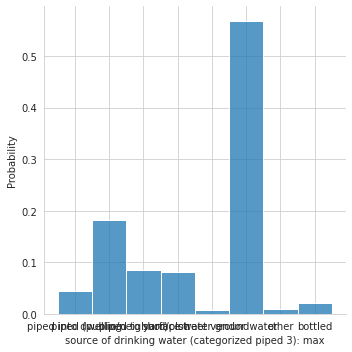

In [160]:
cluster_df6 = cluster_df5
for pre in ["source of drinking water (simplified)", "source of drinking water (categorized by type)",
            "source of drinking water (categorized urban)",
            "source of drinking water (categorized)", "source of drinking water (weights)", 
            "location of source for water (refurbished)",
           "source of drinking water (categorized piped)", "source of drinking water (categorized piped 2)",
           "source of drinking water (categorized piped 3)"]:
    pre += ':'
    select_cols = ["DHSID", "URBAN_RURA"]
    for col in cluster_df5.columns:
        if pre in col:
            select_cols.append(col)
    sub_df = cluster_df5[select_cols]
    print(pre)
    print(sub_df)
    sub_df[pre + ' max'] = sub_df[select_cols[2:]].idxmax(axis=1)
#     print(sub_df[pre + ' max'])
    for i, x in pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows():
        print('asd', x)
#     print(pd.DataFrame(sub_df[pre + ' max'].value_counts()))
    replace_d = {pre + ' max': {c: c[len(pre) + 1:] for c, v in 
                                     pd.DataFrame(sub_df[pre + ' max'].value_counts()).iterrows()}}
    print(replace_d)
    sub_df = sub_df.replace(replace_d)
    print(sub_df)
    print(pre)
    sub_df[pre + ' perc max'] = sub_df[select_cols[1:]].max(axis=1) / sub_df[select_cols[1:]].sum(axis=1) * 100
    print(sub_df[pre + ' max'].value_counts(dropna=False))
#     plot perc max    
#     bins = list(range(1, 101, 5))
#     print(bins)
#     hist = sub_df[pre + ' perc max'].plot.hist(bins=bins)#, density=True)
#     plt.xlim(-5, 315)
#     plt.title(pre[:-1])
#     plt.xlabel("percentage of highest label")
#     plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#     sub_df = sub_df[sub_df['URBAN_RURA'] == 'U']
    sns.displot(sub_df[pre + ' perc max'], stat='probability')
    ax2 = sns.displot(sub_df[pre + ' max'], stat='probability')
    for ax in [ax2]:
        if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
            ax.set_xticklabels(rotation=90)
#     plt.show()

    cluster_df6 = pd.merge(cluster_df6, sub_df[["DHSID", pre + ' max', pre + ' perc max']], how="outer", on=['DHSID'])
    
cluster_df6

In [161]:
#drop na values
pd.set_option('display.float_format', lambda x: '%.10f' % x)
cluster_df6 = cluster_df6[cluster_df6["source of drinking water (simplified): max"].notna()]
cluster_df6 = cluster_df6[cluster_df6["LATNUM"].notna()]
print(len(cluster_df6))
#remove (0,0) pairs
cluster_df6 = cluster_df6[~cluster_df6["LATNUM"].between(0.000000000, 0.00000001)]#5.68434188609e-14)]
print(len(cluster_df6))
cluster_df6["LATNUM"].value_counts(dropna=False)
# cluster_df6[cluster_df6["LATNUM"] == 5.5486260000]

35614
35591


5.8079750000      2
0.4683390000      2
-16.0059720000    2
6.6745950000      2
6.4940190000      2
                 ..
1.1098320000      1
1.0963130000      1
1.1000200000      1
1.4046990000      1
-17.8591140000    1
Name: LATNUM, Length: 35578, dtype: int64

In [162]:
cluster_df6['distance categories cluster'] = np.NaN
replace_l = [-1, 0, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster'])
cluster_df6['distance categories cluster 2'] = np.NaN
replace_l = [-1, 5, 15, 30, 60, 120, 999]
for nr, v in enumerate(replace_l):
    if nr < len(replace_l) - 1:
        cluster_df6['distance categories cluster 2'] = np.where(cluster_df6[
            'time to get to water source (refurbished)'].between(v + 1,
                                        replace_l[nr + 1]), str(v + 1) + ' - ' + str(replace_l[nr + 1]) + ' mins', 
                                             cluster_df6['distance categories cluster 2'])
cluster_df6

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwelling,sou

In [163]:
def split_label_df(df_in, sub_df_ind, split_col_n, force_split_col2, split_amount=6, last_split_as_test=True, force_test_ind=False, img_path=False, excl_outlier_column=False,
                   excl_outlier_std=1):
    """
    Split the label DataFrame according to an x-cross evaluation.

    Parameters
    ----------
    df_in : pandas.DataFrame
        The input label DataFrame to split.
    mode : str
        The mode to use for splitting and labeling the DataFrame. Valid options include:
            - 'split: random': Randomly split the DataFrame into `split_amount` splits.
            - 'split: without <2015': Split the DataFrame into `split_amount` splits, but exclude any rows with a DHSYEAR less than 2015.
            - 'split: country year': Split the DataFrame by unique values of the `GEID` column, ensuring that each split does not contain multiple surveys from the same country.
            - 'split: out of country': Split the DataFrame by unique values of the first two characters of the `GEID` column.
    sub_df_ind : str or bool, optional
        If 'rural', only include rows where the `URBAN_RURA` column is 'R'. If 'urban', only include rows where the `URBAN_RURA` column is 'U'. If 'all' (default) or False, include all rows.
    split_amount : int, optional
        The number of splits to create (default 6).
    last_split_as_test : bool, optional
        If True (default), the last split will be labeled as 'test' instead of 'split N'.
    force_test_ind : str or bool, optional
        If a string is provided, any split containing a row with a value of `force_test_ind` in the column used for splitting will be labeled as 'test'.
         E.g 'MZ' ('split: out of country') or 'MZGE7AFL' ('split: out of country') can be provided to put Mozambique (2018) into the test set.
         If False (default), this behavior is disabled.
    img_path : bool, str
        If the path to the geotiff folder is passed omits rows where there are no geotiffs available else False

    Returns
    -------
    pandas.DataFrame
        The input DataFrame with an additional column indicating the split based on the chosen mode.
    """
    df_in = df_in.copy()
    df = prepare_df(df_in, sub_df_ind, img_path, excl_outlier_column, excl_outlier_std, split_col_n)

    if 'split: random' in split_col_n:
        if 'split: random without <2015' in split_col_n:
            df = df[df['DHSYEAR'] >= 2015]
        df = df.sample(frac=1)
        for i in range(1, split_amount + 1):
            df[split_col_n].iloc[int(len(df)/split_amount) * (i-1): int(len(df)/split_amount) * i] = 'split ' + str(i)
            if i == split_amount and last_split_as_test:
                df[split_col_n].iloc[int(len(df)/split_amount) * (i-1):] = 'test'
        df_in = pd.merge(df_in, df[["DHSID", split_col_n]], how="outer", on=['DHSID'])

    else:
        column = 'split col'
        if 'year' in split_col_n:
            df[column] = df[force_split_col2] + df['DHSYEAR'].astype(int).astype(str)
        else:
            df[column] = df[force_split_col2]
            # Get the unique values of the categorical column
        # else:
        #     raise NotImplementedError(f"Are you sure you provided the correct mode: {mode}")
        # if force_split_col2 == 'adm0_name':
        #     df = df[["DHSID", force_split_col2, column]]
        # else:
        #     df = df[["DHSID", force_split_col2, column, 'adm0_name']]

        # Shuffle the dataframe
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        # Get the unique values of the categorical column
        unique_values = df_shuffled[column].unique()
        # Initialize a dictionary to store the rows for each unique value
        value_rows = {value: df_shuffled[df_shuffled[column] == value] for value in unique_values}
        #print(value_rows)
        # Sort the unique values by decreasing order of count
        sorted_values = {k: v for k, v in sorted(value_rows.items(), key=lambda item: len(item[1]), reverse=True)}
        sorted_dfs = [pd.DataFrame(columns=df.columns) for i in range(split_amount)]
        look_up_d = {i: {} for i in range(split_amount)}
        look_up_d_new = {}
        for unique_value, sub_df in sorted_values.items():
            if sub_df[force_split_col2].iloc[0] not in look_up_d:
                look_up_d_new[sub_df[force_split_col2].iloc[0]] = {}
            # sub_df = sub_df.reset_index(drop=True)
            # #merge a possible pandas Series to a dataframe
            # if isinstance(sub_df, pd.Series):
            #     sub_df = sub_df.to_frame().T
            if 'year' in split_col_n:
                #make sure that it will be sorted into a split where the same country is not in it right now
                put_into_split = False
                for nr, sdf in enumerate(sorted_dfs):
                    if nr not in look_up_d_new[sub_df[force_split_col2].iloc[0]]:
                        look_up_d_new[sub_df[force_split_col2].iloc[0]][nr] = set([])
                    if sub_df['adm0_name'].iloc[0] not in look_up_d_new[sub_df[force_split_col2].iloc[0]][nr]:
                        sorted_dfs[nr] = pd.concat([sdf, sub_df])
                        look_up_d_new[sub_df[force_split_col2].iloc[0]][nr].add(sub_df['adm0_name'].iloc[0])
                        put_into_split = True
                        break

                    # if sub_df['adm0_name'].iloc[0] not in look_up_d[nr]:
                    #     look_up_d[nr][sub_df['adm0_name'].iloc[0]] = set([])
                    # if sub_df[force_split_col2].iloc[0] not in look_up_d[nr][sub_df['adm0_name'].iloc[0]]:
                    #     sorted_dfs[nr] = pd.concat([sdf, sub_df])
                    #     look_up_d[nr][sub_df['adm0_name'].iloc[0]].add(sub_df[force_split_col2].iloc[0])
                    #     break
                if not put_into_split:
                    #we exceeded the amount of splits
                    sub_df2 = pd.DataFrame(df[column].value_counts()).reset_index()
                    sub_df2.columns = [column, 'amount']
                    # print('country year value counts\n', sub_df)
                    # sub_df2['ctr'] = sub_df2[column].str[:2]
                    print('value counts\n', sub_df2)
                    print(split_col_n)
                    # print(look_up_d[sub_df['adm0_name'].iloc[0]])
                    print(f"To many surveys for {sub_df[force_split_col2].iloc[0]} cannot sort in without putting multiple surveys of that country into one split")
                    #sort the following by the amount of unique values
                    print(df.groupby(force_split_col2)[column].nunique().sort_values())
                    # print(df.groupby(force_split_col2)[column].unique())
                    print(df[df[force_split_col2] == sub_df[force_split_col2].iloc[0]][['DHSYEAR', 'GEID', force_split_col2, 'adm0_name']].value_counts())
                    raise NotImplementedError("Possibly just raise the amount of splits")
            else:
                #concat the sub_df of unique_value to the shortest df
                sorted_dfs[0] = pd.concat([sorted_dfs[0], sub_df])
            #sort so that always the df with the least amount of rows is on pos 0
            sorted_dfs = sorted(sorted_dfs, key=lambda x: len(x))
        for nr, fdf in enumerate(sorted_dfs):
            #add the split indicator
            fdf[split_col_n] = 'split ' + str(nr + 1)
            #if e.g. MZ is forced to test ds
            if force_test_ind in fdf[column].values:
                fdf[split_col_n] = 'test'
            elif not force_test_ind and last_split_as_test and nr + 1 == len(sorted_dfs):
                fdf[split_col_n] = 'test'
        #stick everything together
        fdf = pd.concat([sdf for sdf in sorted_dfs])
        df_in = pd.merge(df_in, fdf[["DHSID", split_col_n]], how="outer", on=['DHSID'])
    # if sub_df_ind == 'all':
    #     print('\n', split_col_n)
    #     for split in df_in[split_col_n].unique():
    #         sub_df = df_in[df_in[split_col_n] == split]
    #         print(split, 'amount:', len(sub_df), 'mean:', sub_df['PCA w_location_weighting all'].mean(), 'STD:', sub_df['PCA w_location_weighting all'].std())
    #         sub_df['PCA w_location_weighting all'].hist(bins=100)
    #         plt.show()
    return df_in

In [164]:
def prepare_df(df_in, sub_df_ind, img_path, excl_outlier_column, excl_outlier_std, split_col_n):
    df = df_in.copy()
    # df_in['country'] = df_in["GEID"].str[:2]
    # df = df_in[["DHSID", "GEID", "DHSYEAR", "country", "URBAN_RURA", "TIF_name", 'PCA w_location_weighting all']].copy()
    df[split_col_n] = np.NaN
    #restrict to specified area type
    if sub_df_ind == 'rural':
        df = df[df['URBAN_RURA'] == 'R']
    elif sub_df_ind == 'urban':
        df = df[df['URBAN_RURA'] == 'U']
    elif sub_df_ind is False or sub_df_ind == 'all':
        pass
    else:
        raise NotImplementedError()
    #reducing to available images
    if img_path:
        available_files = hu.files_in_folder(img_path, return_pathes=False)
        df["TIF_name"] = df['TIF_name'].apply(lambda x: x if x in available_files else np.NaN)
        df = df[df["TIF_name"].notna()]
    #excluding outlier surveys (e.g. Egypt, South-Africa)
    if excl_outlier_column:
        mean = df[excl_outlier_column].mean()
        std = df[excl_outlier_column].std()
        print(split_col_n, excl_outlier_column, 'mean:', mean, 'STD', std)
        for cy in df["GEID"].unique():
            sub_df = df[df["GEID"] == cy]
            sub_mean = sub_df[excl_outlier_column].mean()
            # print('sub_mean', sub_mean, 'vs', mean, 'std', std, 'exclstd', excl_outlier_std)
            if sub_mean > mean + excl_outlier_std * std or sub_mean < mean - excl_outlier_std * std:
                print('dropping', cy, 'amount:', len(sub_df), 'mean:', sub_mean, 'vs', mean)
                sub_df['PCA w_location_weighting all'].hist(bins=50, density=1)
                plt.savefig(projects_p + '/imgs/excl_surveys/' + sub_df_ind + '_' + cy + '_' + sub_df['adm0_name'].iloc[0] + '_' + str(int(sub_df['DHSYEAR'].iloc[0])) + '.png')
                # plt.show()
                plt.clf()
                #iteratively removing surveys with high deviation of parent distribution (measured on mean)
                df = df[df["GEID"] != cy]
    return df



def visualize_splits(df, value_col, split_col_n, force_split_col):
    print('\n', split_col_n, ' Whole ds mean/std', df[value_col].mean(), df[value_col].std(), df[value_col].min(), df[value_col].max())
    sub_df = df[(df[value_col] > -3.5) & (df[value_col] < 3.5)][value_col]
    sub_df.hist(bins=50, density=1)
    plt.savefig(projects_p + '/imgs/splits/' + split_col_n + '_whole_ds.png')
    # plt.show()
    plt.clf()
    sub_df = df[df[split_col_n].notna()]
    print(split_col_n, ' Whole ds without excluded areas mean/std', sub_df[value_col].mean(), sub_df[value_col].std(), sub_df[value_col].min(), sub_df[value_col].max())
    sub_df = sub_df[(sub_df[value_col] > -3.5) & (sub_df[value_col] < 3.5)][value_col]
    sub_df.hist(bins=50, density=1)
    plt.savefig(projects_p + '/imgs/splits/' + split_col_n + '_whole_ds_wo_excluded_areas.png')
    # plt.show()
    plt.clf()
    for s in df[split_col_n].unique():
        split_data = df[df[split_col_n] == s][value_col]
        #test for isna with possible str input
        if pd.isnull(s):
            split_data = df[df[split_col_n].isna()][value_col]
        # if np.isnan(s):
        #     split_data = df[df[split_col_n].isna()][value_col]
        print(f"{split_col_n} {s}: size={len(split_data)}, mean={split_data.mean():.2f}, std={split_data.std():.2f}, min={split_data.min():.2f}, max={split_data.max():.2f}")
        split_data = split_data[(split_data > -3.5) & (split_data < 3.5)]
        split_data.hist(bins=50, density=1)
        #write len, mean std as header to plot
        plt.title(f"{s}: size={len(split_data)}, mean={split_data.mean():.2f}, std={split_data.std():.2f}")
        plt.savefig(projects_p + '/imgs/splits/' + split_col_n + '_whole_ds_' + str(s) + '.png')

        # plt.show()
        plt.clf()
        # if force_split_col:
        #     print(s, df[df[split_col_n] == s][force_split_col].value_counts())


#write a function that statistically compares the different splits
def stats_of_splits(df, value_col, split_col_n, force_split_col, split_dict):
    split_dict[split_col_n] = {}
    for v in ['mean', 'std', 'size']:
        for spl in list(df[split_col_n].unique()) + ['whole ds', 'without excluded areas and imgs']:
            #how to break here if spl is not a number?
            if pd.isnull(spl):
                continue
            if spl == 'whole ds':
                sub_df = df[value_col]
            elif spl == 'without excluded areas and imgs':
                sub_df = df[df[split_col_n].notna()][value_col]
            else:
                sub_df = df[df[split_col_n] == spl][value_col]
            n = spl + ' ' + v
            if v == 'mean':
                split_dict[split_col_n][n] = sub_df.mean()
            elif v == 'std':
                split_dict[split_col_n][n] = sub_df.std()
            elif v == 'size':
                split_dict[split_col_n][n] = int(len(sub_df))
    # stats_df = pd.DataFrame(split_dict)
    return split_dict


def split_df_accounting_for_mean(df_in, sub_df_ind, value_col, force_split_col, split_col_n, img_path=False, excl_outlier_column=False, excl_outlier_std=1, n_splits=6, force_test_ind=False):
    df = df_in.copy()

    data = prepare_df(df, sub_df_ind, img_path, excl_outlier_column, excl_outlier_std, split_col_n)
    parent_mean, parent_std = data[value_col].agg(['mean', 'std'])

    split_columns = [force_split_col]
    if 'year' in split_col_n:
        split_columns.append('DHSYEAR')
    if 'adm0_name' not in split_columns:
        split_columns.append('adm0_name')

    stats_df = data.groupby(split_columns)[value_col].agg(['mean', 'count']).reset_index()
    # stats_df = stats_df[stats_df['mean'].notna()]
    stats_df['mean_diff_w'] = (stats_df['mean'] - parent_mean) * stats_df['count']/stats_df['count'].mean()
    stats_df['mean_abs_w'] = np.abs(stats_df['mean_diff_w'])
    #create a balanced weighting from 'mean_abs_w' and 'count'
    stats_df['sort_score'] = stats_df['mean_abs_w']/stats_df['mean_abs_w'].std() + (stats_df['count'] - stats_df['count'].mean()) / stats_df['count'].std()
    stats_df = stats_df.sort_values(['sort_score'], ascending=[False])
    print(stats_df)
    splits = [[] for _ in range(n_splits)]

    #check if other years of the same are already have been added to the split
    look_up_d = {i: {} for i in range(n_splits)}
    for k, (j, row1) in enumerate(stats_df.iterrows()):
        best_split = None
        min_score = float('inf')
        str_l = []
        for nr, split in enumerate(splits):
            if row1['adm0_name'] not in look_up_d[nr]:
                look_up_d[nr][row1['adm0_name']] = set([])

            temp_split = split + [row1]
            if split:
                try:
                    combined_mean_diff = np.nanmean([row['mean_diff_w'] for row in split])
                except RuntimeWarning:
                    combined_mean_diff = 0
            else:
                combined_mean_diff = 0
            try:
                combined_mean_diff_new = abs(np.nanmean([row['mean_diff_w'] for row in temp_split]))
            except RuntimeWarning:
                    combined_mean_diff = 0
            # if pd.isnull(combined_mean_diff_new):
            #     combined_mean_diff_new = combined_mean_diff
            #     if pd.isnull(combined_mean_diff_new):
            #         combined_mean_diff_new = 0.5


            #add penalty if the mean goes into the wrong direction
            if combined_mean_diff <= 0 <= row1['mean_diff_w'] or row1['mean_diff_w'] <= 0 <= combined_mean_diff or len(split) == 0:
                penalty = 0
            else:
                penalty = combined_mean_diff_new

            # Calculate the penalty based on the difference of summed counts between the splits
            counts = [sum([r['count'] for r in s] + [row1['count']]) for s in splits]
            count_local = sum([r['count'] for r in split]) + row1['count']
            count_penalty =  3 * max(parent_std, combined_mean_diff_new) * (count_local - np.min(counts))/count_local * (len(stats_df)/2 + k/2)/len(stats_df)
            score = combined_mean_diff_new + count_penalty + penalty
            str_l.append([nr, count_local, score, combined_mean_diff, combined_mean_diff_new, count_penalty, penalty, row1['mean_diff_w'], row1['count']])

            if score < min_score and row1[force_split_col] not in look_up_d[nr][row1['adm0_name']]:
                min_score = score
                best_split = nr
        # print('appending', 'to', best_split)
        if best_split is None:
            print(split_col_n)
            #sort the following by the amount of unique values
            # print(data.groupby(force_split_col)[force_split_col].nunique().sort_values())
            print(df[df[force_split_col] == row1[force_split_col]][['DHSYEAR', 'GEID', force_split_col, 'adm0_name']].value_counts())
            print(stats_df[stats_df[force_split_col] == row1[force_split_col]][split_columns].value_counts())
            print(f"To many surveys for {row1[force_split_col]} cannot sort in without putting multiple surveys of that country into one split")
            raise NotImplementedError("Possibly just raise the amount of splits")

        # if str_l[best_split][1] == max(c[1] for c in str_l) and k >= 2:
        #     for str_gen in str_l:
        #         print(f"k {k} split {str_gen[0]} count {str_gen[1]} score {str_gen[2]} combined_mean_diff {str_gen[3]} combined_mean_diff_new {str_gen[4]} count_penalty {str_gen[5]} penalty {str_gen[6]} row mean diff w {str_gen[7]} row count {str_gen[8]}")
        splits[best_split].append(row1)
        look_up_d[best_split][row1['adm0_name']].add(row1[force_split_col])

    # Create a dictionary to map group keys (tuple of values from groupby_cols) to their split assignments
    split_assignments = {tuple(row[split_columns]): i for i, country_group in enumerate(splits) for row in country_group}
    # Update the 'Split' column in the input data with the split assignments
    data[split_col_n] = data[split_columns].apply(lambda x: f'split {split_assignments[tuple(x)]}', axis=1)

    #assign a test split to either Mozambique or to split 0
    if force_test_ind:
        if isinstance(force_test_ind, str):
            split_n = data[data['adm0_name'] == force_test_ind][split_col_n].iloc[0]
        elif isinstance(force_test_ind, tuple):
            split_n = data[(data['adm0_name'] == force_test_ind[0]) & (data['DHSYEAR'] == force_test_ind[1])][split_col_n].iloc[0]
        else:
            raise ValueError(f'This should not happen force_test_ind is {force_test_ind}')
    else:
        split_n = 'split 0'
    for unq in data[split_col_n].unique():
        print(unq, len(data[data[split_col_n] == unq]), data[data[split_col_n] == unq][value_col].mean())
    data.loc[data[split_col_n] == split_n, split_col_n] = 'test'

    df = pd.merge(df, data[["DHSID", split_col_n]], how="outer", on='DHSID')
    return df

In [165]:
# print(cluster_df6[cluster_df6['adm0_name'] == 'Mozambique'][['DHSYEAR', 'GEID', 'adm1_name', 'adm0_name']].value_counts())
print(list(cluster_df6.columns))
cluster_df6[cluster_df6['adm1_name'] == 'Androy'][['DHSYEAR', 'GEID', 'PCA w_location_weighting all', 'URBAN_RURA', 'source of drinking water (weights)', 'time to get to water source (refurbished)', 'weighting (location)']]

['DHSID', 'cluster number', 'household number', 'month of interview', 'year of interview', 'number of household members', 'water shortages', 'time to get to water source (minutes)', 'source of drinking water (weights)', 'time to get to water source (refurbished)', 'penalty (location)', 'weighting (location)', 'time to get to water source (refurbished) + penalty', 'time to get to water source (refurbished) + penalty (capped)', 'distance categories num', 'distance categories num 2', 'PCA cat_distance urban', 'PCA cat_distance rural', 'PCA cat_distance all', 'PCA min urban', 'PCA min rural', 'PCA min all', 'PCA w_location_weighting urban', 'PCA w_location_weighting rural', 'PCA w_location_weighting all', 'PCA w_penalty urban', 'PCA w_penalty rural', 'PCA w_penalty all', 'DHSYEAR', 'URBAN_RURA', 'LATNUM', 'LONGNUM', 'adm0_name', 'adm1_name', 'adm2_name', 'GEID', 'TIF_name', 'households', 'Std Deviation: month of interview', 'Std Deviation: water shortages', 'Std Deviation: time to get to w

,DHSYEAR,GEID,PCA w_location_weighting all,URBAN_RURA,source of drinking water (weights),time to get to water source (refurbished),weighting (location)
15344,2011.0000000000,MDGE61FL,NaN,R,1.4333333333,NaN,1.0000000000
15345,2011.0000000000,MDGE61FL,NaN,R,1.5714285714,NaN,1.0000000000
15346,2011.0000000000,MDGE61FL,NaN,R,1.1935483871,NaN,1.0000000000
15347,2011.0000000000,MDGE61FL,NaN,R,1.0625000000,NaN,1.0000000000
15348,2011.0000000000,MDGE61FL,NaN,R,1.9032258065,NaN,1.0000000000
15349,2011.0000000000,MDGE61FL,NaN,R,1.0333333333,NaN,1.0000000000
15350,2011.0000000000,MDGE61FL,NaN,R,1.0312500000,NaN,1.0000000000
15351,2011.0000000000,MDGE61FL,NaN,R,1.0312500000,NaN,1.0000000000
15352,2011.0000000000,MDGE61FL,NaN,R,1.9687500000,NaN,1.0000000000
15353,2011.0000000000,MDGE61FL,NaN,R,1.2187500000,NaN,1.0000000000


In [166]:
cluster_df7 = cluster_df6
stats_d = {}
for mode in [
    'split: random', 'split: random without <2015',
            'split: out of country',
            'split: out of adm1',
            'split: out of adm2',
        ]:
    for sub_df_ind in ['all', 'rural', 'urban']:
        for img_p in [img_path]:#, False]:
            for excl_outlier_column in [False, True]:
                for random in [False, True]:
                    for year in [False, True]:
                        if sub_df_ind == 'all':
                            value_col = 'PCA w_location_weighting all'
                        elif sub_df_ind == 'rural':
                            value_col = 'PCA w_location_weighting rural'
                        elif sub_df_ind == 'urban':
                            value_col = 'PCA w_location_weighting urban'
                        split_col_n = mode
                        if year:
                            split_col_n += ' year'
                        split_col_n += ' ' + sub_df_ind
                        if img_p:
                            split_col_n += ' (w TIF)'
                        if excl_outlier_column:
                            split_col_n += ' excluded outlier surveys'
                            excl_outlier_column = value_col

                        if random:
                            #no doulbe random in name
                            if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                                pass
                            else:
                                split_col_n += ' random'
                        if year:
                            #does not make sense for these
                            if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                                continue
                        if not random:
                            if 'adm2' in split_col_n:
                                print('skipping adm2 split_df_accounting_for_mean')
                                #algo split_df_accounting_for_mean not working for adm2
                                continue
                            if 'split: random' in split_col_n or 'split: random without <2015' in split_col_n:
                                continue
                        # else:
                        #     raise ValueError(f'Should not happen: random is {random} and year is {year}')
                        force_test_ind = False
                        if 'split: out of country' in split_col_n:
                            force_test_ind = 'Mozambique'
                            if 'year' in split_col_n:
                                force_test_ind = ('Mozambique', 2018)
                        force_split_col = False
                        if 'split: out of country' in split_col_n:
                            force_split_col = 'adm0_name'
                        elif 'split: out of adm1' in split_col_n:
                            force_split_col = 'adm1_name'
                        elif 'split: out of adm2' in split_col_n:
                            force_split_col = 'adm2_name'
                        print(split_col_n)
                        if not random:
                            print('split_df_accounting_for_mean', split_col_n, force_test_ind)
                            print(f'sub_df_ind {sub_df_ind}, value_col {value_col}, force_split_col {force_split_col}, split_col_n {split_col_n}, img_p {img_p}, excl_outlier_column {excl_outlier_column}, force_test_ind={force_test_ind}')
                            cluster_df7 = split_df_accounting_for_mean(cluster_df7, sub_df_ind, value_col, force_split_col, split_col_n, img_p, excl_outlier_column, force_test_ind=force_test_ind)
                        else:
                            print('split_label_df', split_col_n)
                            cluster_df7 = split_label_df(cluster_df7, sub_df_ind, split_col_n, force_split_col, force_test_ind=force_test_ind, img_path=img_p, excl_outlier_column=excl_outlier_column)
                        visualize_splits(cluster_df7, value_col, split_col_n, force_split_col)
                        stats_d = stats_of_splits(cluster_df7, value_col, split_col_n, force_split_col, stats_d)
plt.close('all')

split: random all (w TIF)
split_label_df split: random all (w TIF)


/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random all (w TIF)  Whole ds mean/std 0.07570129964111938 1.0923867062024075 -6.730273123323536 3.5103571924973505
split: random all (w TIF)  Whole ds without excluded areas mean/std 0.09386052840391136 1.0840726964091478 -6.730273123323536 3.5103571924973505
split: random all (w TIF) nan: size=7758, mean=0.01, std=1.12, min=-5.94, max=3.51
split: random all (w TIF) split 3: size=4638, mean=0.07, std=1.08, min=-6.73, max=3.51
split: random all (w TIF) split 4: size=4638, mean=0.10, std=1.09, min=-4.67, max=3.51
split: random all (w TIF) split 5: size=4638, mean=0.08, std=1.08, min=-5.05, max=3.51
split: random all (w TIF) test: size=4643, mean=0.08, std=1.07, min=-3.93, max=3.51
split: random all (w TIF) split 1: size=4638, mean=0.11, std=1.09, min=-3.66, max=3.51
split: random all (w TIF) split 2: size=4638, mean=0.12, std=1.11, min=-6.13, max=3.51
split: random all (w TIF) excluded outlier surveys
split_label_df split: random all (w TIF) excluded outlier surveys
split: rando

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



split: random all (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std 0.01751957159967855 1.0116184792361866 -6.730273123323536 3.5103571924973505
split: random all (w TIF) excluded outlier surveys nan: size=9475, mean=0.26, std=1.30, min=-5.94, max=3.51
split: random all (w TIF) excluded outlier surveys split 1: size=4352, mean=0.03, std=1.02, min=-5.05, max=3.51
split: random all (w TIF) excluded outlier surveys split 5: size=4352, mean=0.01, std=1.01, min=-6.13, max=3.51
split: random all (w TIF) excluded outlier surveys split 4: size=4352, mean=0.01, std=0.98, min=-4.03, max=3.44
split: random all (w TIF) excluded outlier surveys test: size=4356, mean=0.02, std=1.01, min=-4.00, max=3.51
split: random all (w TIF) excluded outlier surveys split 3: size=4352, mean=0.00, std=1.01, min=-4.74, max=3.51
split: random all (w TIF) excluded outlier surveys split 2: size=4352, mean=0.03, std=1.03, min=-6.73, max=3.51
split: random rural (w TIF)
split_label_df split: ran

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random rural (w TIF)  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: random rural (w TIF)  Whole ds without excluded areas mean/std 0.07791797827596002 0.9598507678590024 -6.304343835903115 5.074859151941
split: random rural (w TIF) nan: size=17808, mean=-0.07, std=0.87, min=-5.66, max=5.07
split: random rural (w TIF) split 1: size=2963, mean=0.10, std=0.98, min=-5.76, max=5.07
split: random rural (w TIF) split 5: size=2963, mean=0.11, std=1.01, min=-5.00, max=5.07
split: random rural (w TIF) split 3: size=2963, mean=0.08, std=0.94, min=-3.62, max=5.07
split: random rural (w TIF) test: size=2968, mean=0.06, std=0.95, min=-6.30, max=5.07
split: random rural (w TIF) split 4: size=2963, mean=0.06, std=0.93, min=-4.31, max=5.07
split: random rural (w TIF) split 2: size=2963, mean=0.06, std=0.96, min=-4.08, max=5.07
split: random rural (w TIF) excluded outlier surveys
split_label_df split: random rural (w TIF) excluded outlier sur

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random rural (w TIF) excluded outlier surveys  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: random rural (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std -0.0187058373234423 0.8205224239858577 -6.304343835903115 5.074859151941
split: random rural (w TIF) excluded outlier surveys nan: size=19333, mean=0.22, std=1.20, min=-5.66, max=5.07
split: random rural (w TIF) excluded outlier surveys split 4: size=2709, mean=-0.01, std=0.86, min=-6.30, max=4.98
split: random rural (w TIF) excluded outlier surveys split 2: size=2709, mean=0.00, std=0.86, min=-4.68, max=5.07
split: random rural (w TIF) excluded outlier surveys test: size=2713, mean=-0.04, std=0.80, min=-3.93, max=4.94
split: random rural (w TIF) excluded outlier surveys split 5: size=2709, mean=-0.03, std=0.79, min=-3.59, max=4.98
split: random rural (w TIF) excluded outlier surveys split 1: size=2709, mean=-0.03, std=0.79, min=-5.76, max=4.50
sp

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random urban (w TIF)  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: random urban (w TIF)  Whole ds without excluded areas mean/std 0.06362121813952946 0.978354955581452 -5.3596228693611625 2.3688193845081833
split: random urban (w TIF) nan: size=25541, mean=0.18, std=0.99, min=-3.11, max=2.37
split: random urban (w TIF) test: size=1675, mean=0.08, std=0.98, min=-4.46, max=2.37
split: random urban (w TIF) split 5: size=1675, mean=0.09, std=0.94, min=-3.99, max=2.37
split: random urban (w TIF) split 4: size=1675, mean=0.06, std=0.97, min=-5.21, max=2.37
split: random urban (w TIF) split 1: size=1675, mean=0.07, std=0.99, min=-4.88, max=2.37
split: random urban (w TIF) split 2: size=1675, mean=0.04, std=0.99, min=-4.82, max=2.37
split: random urban (w TIF) split 3: size=1675, mean=0.04, std=0.98, min=-5.36, max=2.37
split: random urban (w TIF) excluded outlier surveys
split_label_df split: random urban (w TIF) excluded outl

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random urban (w TIF) excluded outlier surveys  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: random urban (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std -0.037829606740334046 0.9061442097580991 -5.3596228693611625 2.3688193845081833
split: random urban (w TIF) excluded outlier surveys nan: size=26633, mean=0.42, std=1.09, min=-3.11, max=2.37
split: random urban (w TIF) excluded outlier surveys split 2: size=1493, mean=-0.02, std=0.93, min=-5.21, max=2.37
split: random urban (w TIF) excluded outlier surveys split 1: size=1493, mean=-0.02, std=0.91, min=-3.99, max=2.37
split: random urban (w TIF) excluded outlier surveys split 3: size=1493, mean=-0.05, std=0.93, min=-5.36, max=2.37
split: random urban (w TIF) excluded outlier surveys test: size=1493, mean=-0.07, std=0.87, min=-4.82, max=2.37
split: random urban (w TIF) excluded outlier surveys split 5: size=1493, mean=-0.09, std=0.89, min=-4.48,

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 all (w TIF)  Whole ds mean/std 0.07570129964111938 1.0923867062024075 -6.730273123323536 3.5103571924973505
split: random without <2015 all (w TIF)  Whole ds without excluded areas mean/std 0.10913018446435807 1.0870613084716305 -6.730273123323536 3.5103571924973505
split: random without <2015 all (w TIF) nan: size=19591, mean=0.05, std=1.10, min=-6.13, max=3.51
split: random without <2015 all (w TIF) split 5: size=2666, mean=0.12, std=1.11, min=-6.73, max=3.51
split: random without <2015 all (w TIF) test: size=2670, mean=0.08, std=1.08, min=-4.23, max=3.51
split: random without <2015 all (w TIF) split 4: size=2666, mean=0.11, std=1.11, min=-4.12, max=3.51
split: random without <2015 all (w TIF) split 2: size=2666, mean=0.13, std=1.10, min=-4.66, max=3.51
split: random without <2015 all (w TIF) split 1: size=2666, mean=0.10, std=1.07, min=-3.30, max=3.51
split: random without <2015 all (w TIF) split 3: size=2666, mean=0.12, std=1.06, min=-4.03, max=3.51
sp

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 all (w TIF) excluded outlier surveys  Whole ds mean/std 0.07570129964111938 1.0923867062024075 -6.730273123323536 3.5103571924973505
split: random without <2015 all (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std 0.037198195619740484 1.0218098064117642 -6.730273123323536 3.5103571924973505
split: random without <2015 all (w TIF) excluded outlier surveys nan: size=20485, mean=0.11, std=1.14, min=-6.13, max=3.51
split: random without <2015 all (w TIF) excluded outlier surveys split 1: size=2517, mean=0.04, std=1.03, min=-5.40, max=3.45
split: random without <2015 all (w TIF) excluded outlier surveys split 4: size=2517, mean=0.03, std=1.01, min=-4.66, max=3.45
split: random without <2015 all (w TIF) excluded outlier surveys split 3: size=2517, mean=0.05, std=1.00, min=-3.66, max=3.51
split: random without <2015 all (w TIF) excluded outlier surveys split 2: size=2517, mean=0.03, std=1.03, min=-6.73, max=3.51
split: random without <20

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 rural (w TIF)  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: random without <2015 rural (w TIF)  Whole ds without excluded areas mean/std 0.09171105312728921 0.9696137255569309 -6.304343835903115 5.074859151941
split: random without <2015 rural (w TIF) nan: size=25439, mean=0.01, std=0.92, min=-5.76, max=5.07
split: random without <2015 rural (w TIF) split 4: size=1692, mean=0.06, std=0.97, min=-4.25, max=5.07
split: random without <2015 rural (w TIF) split 1: size=1692, mean=0.12, std=0.98, min=-5.00, max=5.07
split: random without <2015 rural (w TIF) test: size=1692, mean=0.09, std=1.00, min=-6.30, max=5.07
split: random without <2015 rural (w TIF) split 3: size=1692, mean=0.08, std=0.93, min=-2.91, max=5.07
split: random without <2015 rural (w TIF) split 2: size=1692, mean=0.08, std=0.95, min=-3.73, max=5.07
split: random without <2015 rural (w TIF) split 5: size=1692, mean=0.13, std=0.99, min=-3.62, 

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 rural (w TIF) excluded outlier surveys  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: random without <2015 rural (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std -0.010093740804308197 0.8189437939090188 -6.304343835903115 5.074859151941
split: random without <2015 rural (w TIF) excluded outlier surveys nan: size=26342, mean=0.08, std=1.02, min=-5.76, max=5.07
split: random without <2015 rural (w TIF) excluded outlier surveys split 1: size=1541, mean=-0.02, std=0.81, min=-4.25, max=3.81
split: random without <2015 rural (w TIF) excluded outlier surveys test: size=1544, mean=0.02, std=0.82, min=-5.00, max=5.07
split: random without <2015 rural (w TIF) excluded outlier surveys split 4: size=1541, mean=-0.03, std=0.82, min=-6.30, max=4.50
split: random without <2015 rural (w TIF) excluded outlier surveys split 5: size=1541, mean=-0.04, std=0.81, min=-2.90, max=4.33
split: random wit

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 urban (w TIF)  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: random without <2015 urban (w TIF)  Whole ds without excluded areas mean/std 0.0720188795175677 0.9786739665587963 -5.3596228693611625 2.3688193845081833
split: random without <2015 urban (w TIF) nan: size=29743, mean=0.10, std=0.99, min=-4.14, max=2.37
split: random without <2015 urban (w TIF) split 4: size=974, mean=0.08, std=1.02, min=-5.36, max=2.37
split: random without <2015 urban (w TIF) split 2: size=974, mean=0.07, std=0.95, min=-4.25, max=2.37
split: random without <2015 urban (w TIF) split 1: size=974, mean=0.08, std=0.96, min=-5.21, max=2.37
split: random without <2015 urban (w TIF) test: size=978, mean=0.10, std=0.96, min=-3.85, max=2.37
split: random without <2015 urban (w TIF) split 3: size=974, mean=0.05, std=0.99, min=-4.88, max=2.37
split: random without <2015 urban (w TIF) split 5: size=974, mean=0.05, std=0.99, min=-4.46

/tmp/ipykernel_1263240/2953691338.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 split: random without <2015 urban (w TIF) excluded outlier surveys  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: random without <2015 urban (w TIF) excluded outlier surveys  Whole ds without excluded areas mean/std -0.0552689253808601 0.9129288705452757 -5.3596228693611625 2.3688193845081833
split: random without <2015 urban (w TIF) excluded outlier surveys nan: size=30374, mean=0.19, std=1.02, min=-4.14, max=2.37
split: random without <2015 urban (w TIF) excluded outlier surveys split 2: size=869, mean=-0.03, std=0.91, min=-4.88, max=2.37
split: random without <2015 urban (w TIF) excluded outlier surveys split 1: size=869, mean=-0.05, std=0.92, min=-4.46, max=2.31
split: random without <2015 urban (w TIF) excluded outlier surveys split 3: size=869, mean=-0.09, std=0.89, min=-5.21, max=2.37
split: random without <2015 urban (w TIF) excluded outlier surveys split 4: size=869, mean=-0.04, std=0.92, min=-4.46, max=2.37
split: ran

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year all (w TIF) random  Whole ds mean/std 0.07570129964111938 1.0923867062024075 -6.730273123323536 3.5103571924973505
split: out of country year all (w TIF) random  Whole ds without excluded areas mean/std 0.09386052840391136 1.0840726964091478 -6.730273123323536 3.5103571924973505
split: out of country year all (w TIF) random nan: size=7758, mean=0.01, std=1.12, min=-5.94, max=3.51
split: out of country year all (w TIF) random split 1: size=4582, mean=0.01, std=1.00, min=-6.73, max=3.51
split: out of country year all (w TIF) random split 4: size=4688, mean=0.13, std=1.20, min=-4.74, max=3.51
split: out of country year all (w TIF) random split 2: size=4583, mean=0.28, std=1.20, min=-6.13, max=3.51
split: out of country year all (w TIF) random split 3: size=4583, mean=0.21, std=1.05, min=-2.96, max=3.51
split: out of country year all (w TIF) random split 6: size=4702, mean=-0.03, std=0.98, min=-5.40, max=3.51
split: out of country year all (w TIF) random split 

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year all (w TIF) excluded outlier surveys random  Whole ds mean/std 0.07570129964111938 1.0923867062024075 -6.730273123323536 3.5103571924973505
split: out of country year all (w TIF) excluded outlier surveys random  Whole ds without excluded areas mean/std 0.01751957159967855 1.0116184792361866 -6.730273123323536 3.5103571924973505
split: out of country year all (w TIF) excluded outlier surveys random nan: size=9475, mean=0.26, std=1.30, min=-5.94, max=3.51
split: out of country year all (w TIF) excluded outlier surveys random split 5: size=4360, mean=0.00, std=1.06, min=-6.13, max=3.51
split: out of country year all (w TIF) excluded outlier surveys random split 6: size=4364, mean=-0.15, std=0.98, min=-5.40, max=3.51
split: out of country year all (w TIF) excluded outlier surveys random split 3: size=4348, mean=0.07, std=1.07, min=-4.23, max=3.51
split: out of country year all (w TIF) excluded outlier surveys random split 1: size=4348, mean=-0.01, std=0.92, min

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year rural (w TIF) random  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: out of country year rural (w TIF) random  Whole ds without excluded areas mean/std 0.07791797827596002 0.9598507678590024 -6.304343835903115 5.074859151941
split: out of country year rural (w TIF) random nan: size=17808, mean=-0.07, std=0.87, min=-5.66, max=5.07
split: out of country year rural (w TIF) random split 3: size=2929, mean=-0.00, std=0.87, min=-3.73, max=5.07
split: out of country year rural (w TIF) random split 6: size=3004, mean=-0.08, std=0.76, min=-5.76, max=4.10
split: out of country year rural (w TIF) random split 4: size=2988, mean=-0.00, std=0.97, min=-5.00, max=5.07
split: out of country year rural (w TIF) random split 1: size=2929, mean=0.28, std=1.09, min=-3.47, max=5.07
split: out of country year rural (w TIF) random split 2: size=2929, mean=0.13, std=1.09, min=-6.30, max=4.98
split: out of country year rural (w TIF

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year rural (w TIF) excluded outlier surveys random  Whole ds mean/std 0.044642346752005686 0.9439420056169637 -6.304343835903115 5.074859151941
split: out of country year rural (w TIF) excluded outlier surveys random  Whole ds without excluded areas mean/std -0.0187058373234423 0.8205224239858577 -6.304343835903115 5.074859151941
split: out of country year rural (w TIF) excluded outlier surveys random nan: size=19333, mean=0.22, std=1.20, min=-5.66, max=5.07
split: out of country year rural (w TIF) excluded outlier surveys random split 6: size=2764, mean=-0.06, std=0.86, min=-3.93, max=5.07
split: out of country year rural (w TIF) excluded outlier surveys random split 1: size=2686, mean=-0.06, std=0.75, min=-3.62, max=4.50
split: out of country year rural (w TIF) excluded outlier surveys random split 2: size=2686, mean=0.05, std=0.80, min=-5.00, max=4.33
split: out of country year rural (w TIF) excluded outlier surveys random split 4: size=2687, mean=0.10, std=0

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year urban (w TIF) random  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: out of country year urban (w TIF) random  Whole ds without excluded areas mean/std 0.06362121813952946 0.978354955581452 -5.3596228693611625 2.3688193845081833
split: out of country year urban (w TIF) random nan: size=25541, mean=0.18, std=0.99, min=-3.11, max=2.37
split: out of country year urban (w TIF) random split 1: size=1660, mean=0.13, std=1.13, min=-5.36, max=2.37
split: out of country year urban (w TIF) random split 6: size=1692, mean=0.24, std=1.04, min=-2.73, max=2.37
split: out of country year urban (w TIF) random split 5: size=1691, mean=0.08, std=0.90, min=-4.88, max=2.37
split: out of country year urban (w TIF) random split 4: size=1687, mean=-0.17, std=0.85, min=-4.14, max=2.30
split: out of country year urban (w TIF) random split 2: size=1660, mean=0.19, std=0.98, min=-3.78, max=2.37
split: out of country year urban (

/tmp/ipykernel_1263240/2953691338.py:122: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison




 split: out of country year urban (w TIF) excluded outlier surveys random  Whole ds mean/std 0.08641002781079982 0.9823210545564272 -5.3596228693611625 2.3688193845081833
split: out of country year urban (w TIF) excluded outlier surveys random  Whole ds without excluded areas mean/std -0.037829606740334046 0.9061442097580991 -5.3596228693611625 2.3688193845081833
split: out of country year urban (w TIF) excluded outlier surveys random nan: size=26633, mean=0.42, std=1.09, min=-3.11, max=2.37
split: out of country year urban (w TIF) excluded outlier surveys random split 4: size=1502, mean=-0.16, std=1.04, min=-5.36, max=2.37
split: out of country year urban (w TIF) excluded outlier surveys random split 1: size=1470, mean=-0.08, std=0.86, min=-4.25, max=2.32
split: out of country year urban (w TIF) excluded outlier surveys random split 5: size=1507, mean=0.12, std=0.78, min=-2.59, max=2.32
split: out of country year urban (w TIF) excluded outlier surveys random split 2: size=1471, mean=

In [167]:
data_list = []
for outer_key, inner_dict in stats_d.items():
    temp_dict = {'Split name': outer_key, **inner_dict}
    data_list.append(temp_dict)
# Create the DataFrame
stats_of_splits_df = pd.DataFrame(data_list)
cols = ['Split name'] + [c for c in stats_of_splits_df.columns if 'size' in c] + [c for c in stats_of_splits_df.columns if 'mean' in c] + [c for c in stats_of_splits_df.columns if 'std' in c]
stats_of_splits_df = stats_of_splits_df[cols]
# print(stats_of_splits_df)
# df.set_index('Split name', inplace=True)
stats_of_splits_df.to_csv(out_f[:-4] + 'stats_of_splits.csv')
stats_of_splits_df

,Split name,split 3 size,split 4 size,split 5 size,test size,split 1 size,split 2 size,whole ds size,without excluded areas and imgs size,split 0 size,split 6 size,split 3 mean,split 4 mean,split 5 mean,test mean,split 1 mean,split 2 mean,whole ds mean,without excluded areas and imgs mean,split 0 mean,split 6 mean,split 3 std,split 4 std,split 5 std,test std,split 1 std,split 2 std,whole ds std,without excluded areas and imgs std,split 0 std,split 6 std
0,split: random all (w TIF),4638.0000000000,4638.0000000000,4638.0000000000,4643.0000000000,4638.0000000000,4638.0000000000,35591,27833,NaN,NaN,0.0652455465,0.1034015712,0.0776127320,0.0828833666,0.1095082973,0.1246058930,0.0757012996,0.0938605284,NaN,NaN,1.0759005461,1.0856196165,1.0800948606,1.0664999318,1.0875284723,1.1079746989,1.0923867062,1.0840726964,NaN,NaN
1,split: random all (w TIF) excluded outlier sur...,4352.0000000000,4352.0000000000,4352.0000000000,4356.0000000000,4352.0000000000,4352.0000000000,35591,26116,NaN,NaN,0.0036744654,0.0052187200,0.0137930333,0.0231154434,0.0251125721,0.0341980521,0.0757012996,0.0175195716,NaN,NaN,1.0127986806,0.9769362701,1.0128118942,1.0110891939,1.0249503451,1.0304883915,1.0923867062,1.0116184792,NaN,NaN
2,split: random rural (w TIF),2963.0000000000,2963.0000000000,2963.0000000000,2968.0000000000,2963.0000000000,2963.0000000000,35591,17783,NaN,NaN,0.0838117531,0.0560450943,0.1072277247,0.0607507344,0.0970413984,0.0626041565,0.0446423468,0.0779179783,NaN,NaN,0.9413655694,0.9290388575,1.0075504523,0.9452823156,0.9784568287,0.9550632270,0.9439420056,0.9598507679,NaN,NaN
3,split: random rural (w TIF) excluded outlier s...,2709.0000000000,2709.0000000000,2709.0000000000,2713.0000000000,2709.0000000000,2709.0000000000,35591,16258,NaN,NaN,-0.0019536242,-0.0130418199,-0.0338813172,-0.0387574137,-0.0292393086,0.0046680671,0.0446423468,-0.0187058373,NaN,NaN,0.8226946554,0.8564919207,0.7920077495,0.8036903707,0.7900024748,0.8552887814,0.9439420056,0.8205224240,NaN,NaN
4,split: random urban (w TIF),1675.0000000000,1675.0000000000,1675.0000000000,1675.0000000000,1675.0000000000,1675.0000000000,35591,10050,NaN,NaN,0.0425791698,0.0613663377,0.0871317741,0.0799259833,0.0714821034,0.0391861080,0.0864100278,0.0636212181,NaN,NaN,0.9828387347,0.9730978463,0.9430145735,0.9845040391,0.9918414936,0.9944265629,0.9823210546,0.9783549556,NaN,NaN
5,split: random urban (w TIF) excluded outlier s...,1493.0000000000,1493.0000000000,1493.0000000000,1493.0000000000,1493.0000000000,1493.0000000000,35591,8958,NaN,NaN,-0.0482456680,0.0144186911,-0.0874786998,-0.0660073217,-0.0152158577,-0.0244487844,0.0864100278,-0.0378296067,NaN,NaN,0.9293233083,0.9055676951,0.8916122998,0.8741014495,0.9072723064,0.9255699491,0.9823210546,0.9061442098,NaN,NaN
6,split: random without <2015 all (w TIF),2666.0000000000,2666.0000000000,2666.0000000000,2670.0000000000,2666.0000000000,2666.0000000000,35591,16000,NaN,NaN,0.1208488948,0.1069349142,0.1169072067,0.0816216815,0.0977266402,0.1308016383,0.0757012996,0.1091301845,NaN,NaN,1.0606770132,1.1052327133,1.1124797053,1.0775799369,1.0704201955,1.0952991396,1.0923867062,1.0870613085,NaN,NaN
7,split: random without <2015 all (w TIF) exclud...,2517.0000000000,2517.0000000000,2517.0000000000,2521.0000000000,2517.0000000000,2517.0000000000,35591,15106,NaN,NaN,0.0485150670,0.0268069180,0.0206908828,0.0536591319,0.0414418075,0.0320492069,0.0757012996,0.0371981956,NaN,NaN,1.0015719579,1.0098556565,1.0261338145,1.0294204194,1.0324740252,1.0315922357,1.0923867062,1.0218098064,NaN,NaN
8,split: random without <2015 rural (w TIF),1692.0000000000,1692.0000000000,1692.0000000000,1692.0000000000,1692.0000000000,1692.0000000000,35591,10152,NaN,NaN,0.0785450200,0.0559692056,0.1303112936,0.0897839256,0.1154771847,0.0796961434,0.0446423468,0.0917110531,NaN,NaN,0.9269009628,0.9688129569,0.9932595076,0.9986179408,0.9771757222,0.9503426830,0.9439420056,0.9696137256,NaN,NaN
9,split: random without <2015 rural (w TIF) excl...,1541.0000000000,1541.0000000000,1541.

In [168]:
cluster_df6[cluster_df6['adm1_name'] == 'Melaky'][['adm0_name', 'DHSYEAR']]

,adm0_name,DHSYEAR
15309,Madagascar,2011.0000000000
15310,Madagascar,2011.0000000000
15586,Madagascar,2013.0000000000
15587,Madagascar,2013.0000000000
15588,Madagascar,2013.0000000000
15940,Madagascar,2016.0000000000
15941,Madagascar,2016.0000000000
15942,Madagascar,2016.0000000000
15943,Madagascar,2016.0000000000
15944,Madagascar,2016.0000000000


In [169]:
cluster_df7

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwelling,sou

In [170]:
for col_split_in in ['split: random', 'split: random without <2015']:
    for area_ind in ['all', 'rural', 'urban']:
        col_split = col_split_in + ' ' + area_ind + ' (w TIF)'
        sub_df = cluster_df7[cluster_df7[col_split].notna()]
        for col in sub_df.columns:
            if 'max' in col or 'PCA' in col or col in ['time to get to water source (minutes)',
                                       'time to get to water source (refurbished)', 'time to get to water source (refurbished) + penalty (capped)',
                    'source of drinking water (weights)', 'Std Deviation: time to get to water source (refurbished)',
                                      'distance categories cluster']:
                if 'PCA' in col and not area_ind in col:
                    continue
                sub_sub_df = pd.DataFrame(sub_df[[col, col_split]])
                sub_sub_df = sub_sub_df.dropna()
                if not sub_sub_df.empty:
                    print(col_split)
                    print(col)
                    try:
                        print('len', len(sub_df[col]))
                        print('mean', sub_df[col].mean())
                        print('std', sub_df[col].std())
                    except:
                        pass
                    # print(sub_sub_df)
                    if 'max' in col and not col == 'source of drinking water (simplified): max' and not 'perc max' in col:
                        replace_d = {}
                        values_df = pd.DataFrame(sub_sub_df.value_counts(), columns=[col])
                        for nr, row in enumerate(values_df.iterrows()):
                            print(nr, row)
                            print('asd', row[0][0], row[1][col])
                            if row[1][col] >= len(sub_sub_df[col]) * 0.05:
                                replace_d[row[0][0]] = np.NaN
    #                             if cfg.verbose:
    #                                 print('dropped label:', row[0], 'n:', row[1][col], '< threshold', len(labels_df) * drop)
                        sub_sub_df.replace(replace_d)
                    sub_sub_df = sub_sub_df.dropna()
                    # print(max(sub_sub_df))
                    # print(type(max(sub_sub_df)))
                    # print(sub_sub_df)
    #                 figure = plt.figure(figsize=(2, 1), dpi=300)
    #                 sns.set(font_scale = 1)
                    if not type(max(sub_sub_df[col])) == str and max(sub_sub_df[col]) >= 120:
                        bins = list(range(0, 80, 5))
                        print('% <= 1', len(sub_sub_df[sub_sub_df[col] <= 1])/len(sub_sub_df))
                        ax2 = sns.displot(sub_sub_df[col], stat='probability', bins=bins)
                    else:
                        ax2 = sns.displot(sub_sub_df[col], stat='probability')
                    for ax in [ax2]:
                        if 'max' in col and not 'perc' in col or col == 'distance categories cluster':
                            ax.set_xticklabels(rotation=90)

                    title = col
                    extra_folder = ''
                    x_title = None
    #                 sns.set_style("whitegrid")
                    if col == 'source of drinking water (simplified): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (simplified): perc max':
                        title = 'Source of drinking water'
                    if col == 'PCA w_location_weighting urban':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'PCA w_location_weighting all':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'PCA w_location_weighting rural':
                        title = 'PCA'
                        x_title = 'PC1'
                    if col == 'Std Deviation: PCA w_location_weighting urban':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'Std Deviation: PCA w_location_weighting all':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'Std Deviation: PCA w_location_weighting rural':
                        title = 'PCA'
                        x_title = 'Std Deviation of PC1'
                    if col == 'time to get to water source (refurbished)':
                        title = 'Time to get to water source'
                        x_title = 'Distance [mins]'
                    if col == 'location of source for water (refurbished): max':
                        title = 'Location of source for water'
                    if col == 'source of drinking water (categorized urban): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized urban): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 2): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 2): perc max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 3): max':
                        title = 'Source of drinking water'
                    if col == 'source of drinking water (categorized piped 3): perc max':
                        title = 'Source of drinking water'
                    if title != col:
                        extra_folder = '/chosen/'
                    else:
                        extra_folder = '/others/'
                    if 'perc max' in col:
                        x_title = 'Share of answers in maximum category [%]'

                    title += ' (n=' + str(len(sub_sub_df)) + ')'
                    plt.title(title, fontsize=14)
                    plt.xlabel(x_title, fontsize=14)
                    plt.ylabel('Probability', fontsize=14)
                    plt.grid(True)
    #                 plt.tight_layout()

    #                 plt.tightlayout()
                    plt.savefig(projects_p + '/imgs/' + extra_folder + col_split + '_' + col, dpi=300,
                                bbox_inches="tight", transparent=False)
                    plt.clf()
                    plt.close()

split: random all (w TIF)
time to get to water source (minutes)
len 27833
mean 28.658800044266854
std 29.597700042242113
% <= 1 0.0018890944153646346
split: random all (w TIF)
source of drinking water (weights)
len 27833
mean 2.6538322135031045
std 0.8563781931527286
split: random all (w TIF)
time to get to water source (refurbished)
len 27833
mean 22.205479075200522
std 26.87941184644956
% <= 1 0.06498513052098248
split: random all (w TIF)
time to get to water source (refurbished) + penalty (capped)
len 27833
mean 29.882542420512138
std 24.30055698755992
% <= 1 0.008738113595476741
split: random all (w TIF)
PCA cat_distance all
len 27833
mean 0.08605365542850353
std 1.0080112314462022
split: random all (w TIF)
PCA min all
len 27833
mean 0.06046726148927941
std 0.8692425744094461
split: random all (w TIF)
PCA w_location_weighting all
len 27833
mean 0.09386052840391136
std 1.0840726964091478
split: random all (w TIF)
PCA w_penalty all
len 27833
mean 0.06358008239793927
std 0.88842537052

In [171]:
for col in cluster_df7.columns:
    if 'split' in col:
        print(cluster_df7[col].value_counts(dropna=False, normalize=True)*100)

NaN       21.7976454722
test      13.0454328341
split 3   13.0313843387
split 4   13.0313843387
split 5   13.0313843387
split 1   13.0313843387
split 2   13.0313843387
Name: split: random all (w TIF), dtype: float64
NaN       26.6218987946
test      12.2390491978
split 1   12.2278104015
split 5   12.2278104015
split 4   12.2278104015
split 3   12.2278104015
split 2   12.2278104015
Name: split: random all (w TIF) excluded outlier surveys, dtype: float64
NaN       50.0351212385
test       8.3391868731
split 1    8.3251383777
split 5    8.3251383777
split 3    8.3251383777
split 4    8.3251383777
split 2    8.3251383777
Name: split: random rural (w TIF), dtype: float64
NaN       54.3199123374
test       7.6227136074
split 4    7.6114748110
split 2    7.6114748110
split 5    7.6114748110
split 1    7.6114748110
split 3    7.6114748110
Name: split: random rural (w TIF) excluded outlier surveys, dtype: float64
NaN       71.7625242337
test       4.7062459611
split 5    4.7062459611
split 4   

In [172]:
cluster_df7

,DHSID,cluster number,household number,month of interview,year of interview,number of household members,water shortages,time to get to water source (minutes),source of drinking water (weights),time to get to water source (refurbished),penalty (location),weighting (location),time to get to water source (refurbished) + penalty,time to get to water source (refurbished) + penalty (capped),distance categories num,distance categories num 2,PCA cat_distance urban,PCA cat_distance rural,PCA cat_distance all,PCA min urban,PCA min rural,PCA min all,PCA w_location_weighting urban,PCA w_location_weighting rural,PCA w_location_weighting all,PCA w_penalty urban,PCA w_penalty rural,PCA w_penalty all,DHSYEAR,URBAN_RURA,LATNUM,LONGNUM,adm0_name,adm1_name,adm2_name,GEID,TIF_name,households,Std Deviation: month of interview,Std Deviation: water shortages,Std Deviation: time to get to water source (minutes),Std Deviation: source of drinking water (weights),Std Deviation: time to get to water source (refurbished),Std Deviation: penalty (location),Std Deviation: weighting (location),Std Deviation: time to get to water source (refurbished) + penalty,Std Deviation: time to get to water source (refurbished) + penalty (capped),Std Deviation: distance categories num,Std Deviation: distance categories num 2,Std Deviation: PCA cat_distance urban,Std Deviation: PCA cat_distance rural,Std Deviation: PCA cat_distance all,Std Deviation: PCA min urban,Std Deviation: PCA min rural,Std Deviation: PCA min all,Std Deviation: PCA w_location_weighting urban,Std Deviation: PCA w_location_weighting rural,Std Deviation: PCA w_location_weighting all,Std Deviation: PCA w_penalty urban,Std Deviation: PCA w_penalty rural,Std Deviation: PCA w_penalty all,source of drinking water (simplified): bottled,source of drinking water (simplified): other,source of drinking water (simplified): piped into dwelling,source of drinking water (simplified): piped to neighbor,source of drinking water (simplified): piped to yard/plot,source of drinking water (simplified): protected spring,source of drinking water (simplified): protected well,source of drinking water (simplified): public tap/standpipe,source of drinking water (simplified): rainwater,source of drinking water (simplified): sachet,source of drinking water (simplified): street vendor,source of drinking water (simplified): surface water,source of drinking water (simplified): tube well or borehole,source of drinking water (simplified): unprotected spring,source of drinking water (simplified): unprotected well,source of drinking water (categorized by type): bottled,source of drinking water (categorized by type): other,source of drinking water (categorized by type): piped,source of drinking water (categorized by type): spring,source of drinking water (categorized by type): street vendor,source of drinking water (categorized by type): surface water,source of drinking water (categorized by type): tube well or borehole,source of drinking water (categorized by type): well,source of drinking water (categorized urban): bottled,source of drinking water (categorized urban): groundwater,source of drinking water (categorized urban): other,source of drinking water (categorized urban): piped,source of drinking water (categorized urban): street vendor,source of drinking water (categorized urban): surface water,source of drinking water (categorized piped): bottled,source of drinking water (categorized piped): groundwater,source of drinking water (categorized piped): other,source of drinking water (categorized piped): other piped,source of drinking water (categorized piped): piped into dwelling,source of drinking water (categorized piped): street vendor,source of drinking water (categorized piped): surface water,source of drinking water (categorized piped 2): bottled,source of drinking water (categorized piped 2): groundwater,source of drinking water (categorized piped 2): other,source of drinking water (categorized piped 2): piped into dwelling,sou

In [173]:
cluster_df7.to_csv(out_f, index=False)

In [174]:
df["source of drinking water (simplified)"].value_counts()

tube well or borehole    194237
public tap/standpipe     141135
unprotected well         108107
surface water             95023
protected well            85456
piped to yard/plot        79556
unprotected spring        52760
protected spring          49586
piped into dwelling       45665
piped to neighbor         26190
sachet                    21555
street vendor             10017
rainwater                  8953
bottled                    5739
other                      5496
Name: source of drinking water (simplified), dtype: int64

In [175]:
#Export for Pranti/ Imputation
df2 = df[["DHSID", "GEID", "country code and phase", "year of interview", "URBAN_RURA", "region", "source of drinking water (simplified)", "time to get to water source (minutes)", "location of source for water", "anything done to water to make safe to drink",  "source of drinking water (categorized by type)", "source of drinking water (weights)", "water shortages", "PCA w_location_weighting all", "source of drinking water (categorized piped)", "source of drinking water (categorized piped 2)", "source of drinking water (categorized piped 3)"]]
df2.to_csv(out_f_hh, index=False)
df2


,DHSID,GEID,country code and phase,year of interview,URBAN_RURA,region,source of drinking water (simplified),time to get to water source (minutes),location of source for water,anything done to water to make safe to drink,source of drinking water (categorized by type),source of drinking water (weights),water shortages,PCA w_location_weighting all,source of drinking water (categorized piped),source of drinking water (categorized piped 2),source of drinking water (categorized piped 3)
0,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.5103571925,piped into dwelling,piped into dwelling,piped into dwelling
1,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.5103571925,piped into dwelling,piped into dwelling,piped into dwelling
2,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.5103571925,piped into dwelling,piped into dwelling,piped into dwelling
3,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.5103571925,piped into dwelling,piped into dwelling,piped into dwelling
4,AO201100000001,AOGE61FL,AO5,2011.0000000000,U,mesoendemica estavel,piped into dwelling,NaN,NaN,NaN,piped,5.0000000000,NaN,3.5103571925,piped into dwelling,piped into dwelling,piped into dwelling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931373,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,yes,well,3.0000000000,0.0000000000,1.2133312017,groundwater,groundwater,groundwater
931374,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,no,well,3.0000000000,0.0000000000,1.2133312017,groundwater,groundwater,groundwater
931375,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,unprotected well,10.0000000000,elsewhere,yes,well,2.0000000000,0.0000000000,-0.5607834473,groundwater,groundwater,groundwater
931376,ZW201500000400,ZWGE72FL,ZW7,2015.0000000000,R,mashonaland east,protected well,NaN,in own yard/plot,no,well,3.0000000000,0.0000000000,1.2133312017,groundwater,groundwater,groundwater
